**Source related:**
* source frame mass: m1 and m2 sample from uniform distribution (m1>m2) lim[1,3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn:   sampler_sine  [0, np.pi]

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

**SNR related:**
* Waveform_approximant: IMRPhenomD
* No spin
* SNR threshold: 8 (for lensed, only one image detectable, not two)
* PSD: 'L1' (attached) 
  * this was used in PE, as suggested by Justin
* f_min: 20Hz
* sampling frequency: 2048Hz
* delta_f: 1/duration, and the duration is dynamic,  its dependent on the masses, check `gwsnr`'s [chirptime](https://github.com/hemantaph/gwsnr/blob/1de37b036204cc2da35041bdb608ad368684c58e/gwsnr/njit_functions.py#L14)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ler.rates import LeR
from ler.utils import get_param_from_json

In [2]:
ler = LeR(verbose=False)

In [11]:
ler = LeR(npool=6,
          verbose=False, 
          event_type='BNS', 
          mtot_max=51,  # for SNR interpolation
          z_max=5,
          ifos=['L1','H1','V1'],
          snr_type="interpolation",
          source_priors=dict(source_frame_masses='binary_masses_uniform',),
          source_priors_params=dict(
              source_frame_masses=dict(
                  m_min=1,
                  m_max=3,
              ),
          ),
          )

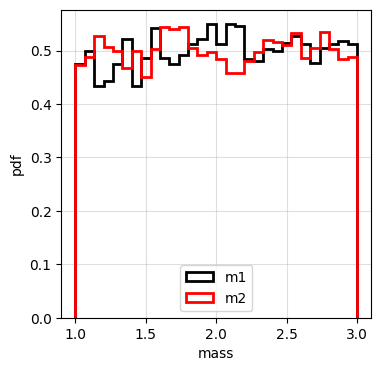

In [12]:
m1,m2 = ler.sample_source_frame_masses(size=10000)
plt.figure(figsize=(4,4))
plt.hist(m1, bins=30, histtype='step', lw=2, color='k', label='m1', density=True)
plt.hist(m2, bins=30, histtype='step', lw=2, color='r', label='m2', density=True)
plt.xlabel('mass')
plt.ylabel('pdf')
plt.legend()
plt.grid(alpha=0.4)
plt.show()


## Un-lensed events

In [47]:
# snr_cut=8.0
ler.selecting_n_unlensed_detectable_events(size=500, batch_size=200000,snr_threshold=8.0, output_jsonfile='n_unlensed_detectable_bns_uniformL1H1V1.json', meta_data_file='n_unlensed_detectable_bns_uniformL1H1V1_meta.json', resume=True);

collected number of detectable events =  0
collected number of detectable events =  10
total number of events =  200000
total unlensed rate (yr^-1): 4.680187172805297
collected number of detectable events =  25
total number of events =  400000
total unlensed rate (yr^-1): 5.850233966006622
collected number of detectable events =  40
total number of events =  600000
total unlensed rate (yr^-1): 6.240249563740396
collected number of detectable events =  53
total number of events =  800000
total unlensed rate (yr^-1): 6.201248003967019
collected number of detectable events =  66
total number of events =  1000000
total unlensed rate (yr^-1): 6.177847068102993
collected number of detectable events =  83
total number of events =  1200000
total unlensed rate (yr^-1): 6.4742589223806615
collected number of detectable events =  90
total number of events =  1400000
total unlensed rate (yr^-1): 6.017383507892525
collected number of detectable events =  103
total number of events =  1600000
total 

In [55]:
# let's see how rate varies with sampling size
meta_data = get_param_from_json('ler_data/n_unlensed_detectable_bns_uniformL1H1V1_meta.json')
meta_data.keys()

dict_keys(['events_total', 'detectable_events', 'total_rate'])

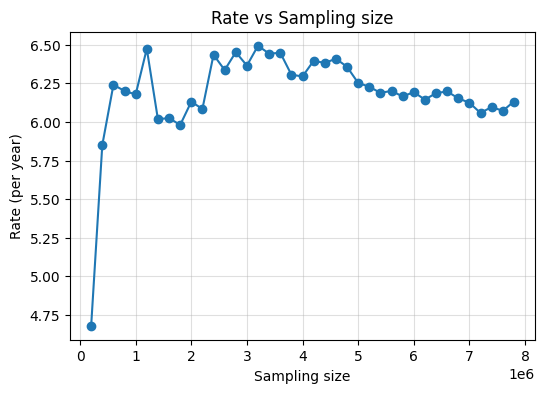

In [56]:
# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [57]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 6e6)[0]
# take average 
rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Rate (per year) =', rate_unlensed)

Rate (per year) = 6.129521503941839


## Lensed events

In [62]:
# snr_cut=8.0
# time will take long time sample
ler.selecting_n_lensed_detectable_events(size=500, batch_size=200000,snr_threshold=8.0, num_img=1, output_jsonfile='n_lensed_detectable_bnsL1H1V1_uniform.json', meta_data_file='n_lensed_detectable_bns_uniformL1H1V1_meta.json', resume=True);

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.46it/s]


collected number of events =  29
total number of events =  200000
total lensed rate (yr^-1): 0.028103177939605904


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


collected number of events =  51
total number of events =  400000
total lensed rate (yr^-1): 0.02471141508482588


100%|█████████████████████████████████████████████████████| 200000/200000 [00:46<00:00, 4263.53it/s]


collected number of events =  75
total number of events =  600000
total lensed rate (yr^-1): 0.024226877534143022


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


collected number of events =  96
total number of events =  800000
total lensed rate (yr^-1): 0.023257802432777298


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of events =  120
total number of events =  1000000
total lensed rate (yr^-1): 0.0232578024327773


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]


collected number of events =  146
total number of events =  1200000
total lensed rate (yr^-1): 0.02358082746656587


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.76it/s]


collected number of events =  176
total number of events =  1400000
total lensed rate (yr^-1): 0.024365316834338124


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


collected number of events =  198
total number of events =  1600000
total lensed rate (yr^-1): 0.023984608758801592


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


collected number of events =  223
total number of events =  1800000
total lensed rate (yr^-1): 0.024011527511617305


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


collected number of events =  250
total number of events =  2000000
total lensed rate (yr^-1): 0.024226877534143022


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.56it/s]


collected number of events =  276
total number of events =  2200000
total lensed rate (yr^-1): 0.024314975270630815


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


collected number of events =  298
total number of events =  2400000
total lensed rate (yr^-1): 0.024065365017248735


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of events =  320
total number of events =  2600000
total lensed rate (yr^-1): 0.023854156341310054


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.07it/s]


collected number of events =  349
total number of events =  2800000
total lensed rate (yr^-1): 0.02415765788404547


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of events =  379
total number of events =  3000000
total lensed rate (yr^-1): 0.02448529756117388


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.74it/s]


collected number of events =  400
total number of events =  3200000
total lensed rate (yr^-1): 0.024226877534143022


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


collected number of events =  427
total number of events =  3400000
total lensed rate (yr^-1): 0.024340886369597813


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of events =  454
total number of events =  3600000
total lensed rate (yr^-1): 0.024442227556668736


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


collected number of events =  482
total number of events =  3800000
total lensed rate (yr^-1): 0.024583905203067233


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


collected number of events =  508
total number of events =  4000000
total lensed rate (yr^-1): 0.024614507574689307
storing detectable lensed params in ./ler_data/n_lensed_detectable_bnsL1H1V1_uniform.json

 trmming final result to size=500


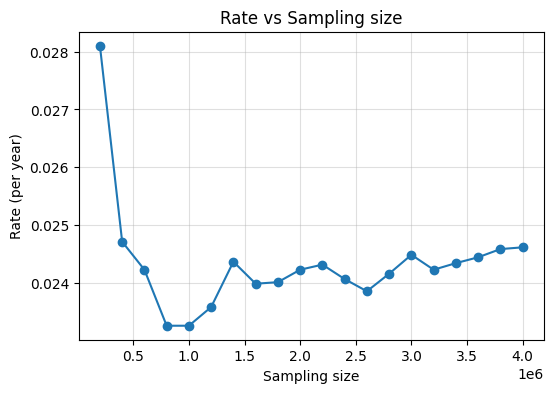

In [63]:
# let's see how rate varies with sampling size
meta_data = get_param_from_json('ler_data/n_lensed_detectable_bns_uniformL1H1V1_meta.json')
# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [64]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 2e6)[0]
# take average 
rate_lensed = np.mean(meta_data['total_rate'][idx])
print('Rate (per year) =', rate_lensed)

Rate (per year) = 0.024308585631257505


In [65]:
# rate comparison
rate_unlensed/rate_lensed

252.15459249344872

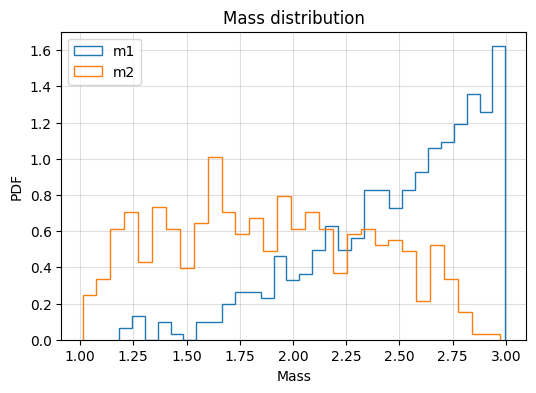

In [44]:
# lensed_params = get_param_from_json('ler_data/n_unlensed_detectable_bnsL1H1V1_uniform.json')
lensed_params = get_param_from_json('ler_data/n_unlensed_detectable_bns_uniformL1H1V1.json')
m1 = lensed_params['mass_1_source']
m2 = lensed_params['mass_2_source']

# plot the mass distribution
plt.figure(figsize=(6,4))
plt.hist(m1, bins=30, histtype='step', label='m1', density=True)
plt.hist(m2, bins=30, histtype='step', label='m2', density=True)
plt.xlabel('Mass')
plt.ylabel('PDF')
plt.legend()
plt.title('Mass distribution')
plt.grid(alpha=0.4)
plt.show()

In [13]:
ler = LeR(npool=8,
          verbose=False, 
          event_type='BNS', 
          mtot_max=51,  # for SNR interpolation
          z_max=5,
          ifos=['L1','H1'],
          snr_type="interpolation",
          source_priors=dict(source_frame_masses='binary_masses_uniform',),
          source_priors_params=dict(
              source_frame_masses=dict(
                  m_min=1,
                  m_max=3,
              ),
          ),
          )

In [16]:
# snr_cut=8.0
# time will take long time sample
ler.selecting_n_unlensed_detectable_events(size=500, batch_size=200000,snr_threshold=8.0, output_jsonfile='n_unlensed_detectable_bns_uniformL1H1.json', meta_data_file='n_unlensed_detectable_bns_uniformL1H1_meta.json', resume=True);

collected number of detectable events =  0
collected number of detectable events =  18
total number of events =  200000
total unlensed rate (yr^-1): 8.424336911049535
collected number of detectable events =  24
total number of events =  400000
total unlensed rate (yr^-1): 5.616224607366357
collected number of detectable events =  34
total number of events =  600000
total unlensed rate (yr^-1): 5.304212129179337
collected number of detectable events =  43
total number of events =  800000
total unlensed rate (yr^-1): 5.031201210765695
collected number of detectable events =  52
total number of events =  1000000
total unlensed rate (yr^-1): 4.86739465971751
collected number of detectable events =  58
total number of events =  1200000
total unlensed rate (yr^-1): 4.524180933711787
collected number of detectable events =  72
total number of events =  1400000
total unlensed rate (yr^-1): 4.81390680631402
collected number of detectable events =  79
total number of events =  1600000
total unle

In [23]:
# snr_cut=8.0
# time will take long time sample
ler.selecting_n_lensed_detectable_events(size=500, batch_size=500000,snr_threshold=8.0, num_img=1, output_jsonfile='n_lensed_detectable_bns_uniformL1H1.json', meta_data_file='n_lensed_detectable_bns_uniformL1H1_meta.json', resume=True);

collected number of detectable events =  444.0


100%|███████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.77it/s]


collected number of events =  493.0
total number of events =  5000000
total lensed rate (yr^-1): 0.019110160998932015


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


collected number of events =  534.0
total number of events =  5500000
total lensed rate (yr^-1): 0.01881767651379254
storing detectable lensed params in ./ler_data/n_lensed_detectable_bns_uniformL1H1.json

 trmming final result to size=500


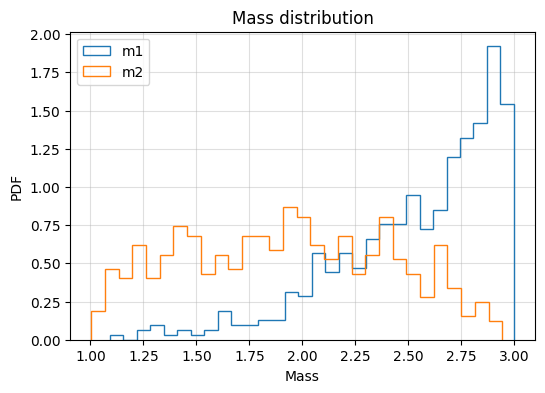

In [41]:
lensed_params = get_param_from_json('ler_data/n_lensed_detectable_bns_uniformL1H1.json')
m1 = lensed_params['mass_1_source']
m2 = lensed_params['mass_2_source']

# plot the mass distribution
plt.figure(figsize=(6,4))
plt.hist(m1, bins=30, histtype='step', label='m1', density=True)
plt.hist(m2, bins=30, histtype='step', label='m2', density=True)
plt.xlabel('Mass')
plt.ylabel('PDF')
plt.legend()
plt.title('Mass distribution')
plt.grid(alpha=0.4)
plt.show()

In [52]:
ler = LeR(npool=8,
          verbose=False, 
          event_type='BNS', 
          mtot_max=51,  # for SNR interpolation
          z_max=5,
          psds={'L1':'custom_psd.txt'},
          snr_type="interpolation",
          source_priors=dict(source_frame_masses='binary_masses_uniform',),
          source_priors_params=dict(
              source_frame_masses=dict(
                  m_min=1,
                  m_max=3,
              ),
          ),
          )

In [53]:
# snr_cut=8.0
ler.selecting_n_unlensed_detectable_events(size=500, batch_size=200000,snr_threshold=8.0, output_jsonfile='n_unlensed_detectable_bns_uniformL1.json', meta_data_file='n_unlensed_detectable_bns_uniforL1_meta.json', resume=False);

collected number of detectable events =  0
collected number of detectable events =  2
total number of events =  200000
total unlensed rate (yr^-1): 0.9360374345610595
collected number of detectable events =  2
total number of events =  400000
total unlensed rate (yr^-1): 0.46801871728052974
collected number of detectable events =  5
total number of events =  600000
total unlensed rate (yr^-1): 0.7800311954675495
collected number of detectable events =  7
total number of events =  800000
total unlensed rate (yr^-1): 0.8190327552409271
collected number of detectable events =  8
total number of events =  1000000
total unlensed rate (yr^-1): 0.7488299476488476
collected number of detectable events =  10
total number of events =  1200000
total unlensed rate (yr^-1): 0.7800311954675495
collected number of detectable events =  13
total number of events =  1400000
total unlensed rate (yr^-1): 0.8691776178066981
collected number of detectable events =  15
total number of events =  1600000
total

In [47]:
# snr_cut=8.0
# time will take long time sample
ler.selecting_n_lensed_detectable_events(size=500, batch_size=200000,snr_threshold=8.0, num_img=1, output_jsonfile='n_lensed_detectable_bns_uniformL1.json', meta_data_file='n_lensed_detectable_bns_uniformL1_meta.json', resume=True);

collected number of detectable events =  36.0


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  36.0
total number of events =  5900000
total lensed rate (yr^-1): 0.0011826001237005407


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.06it/s]


collected number of events =  37.0
total number of events =  6100000
total lensed rate (yr^-1): 0.0011755993032961205


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  39.0
total number of events =  6300000
total lensed rate (yr^-1): 0.001199807268357559


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  41.0
total number of events =  6500000
total lensed rate (yr^-1): 0.0012225255124921402


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  43.0
total number of events =  6700000
total lensed rate (yr^-1): 0.0012438874435440597


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  46.0
total number of events =  6900000
total lensed rate (yr^-1): 0.0012921001351542945


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


collected number of events =  51.0
total number of events =  7100000
total lensed rate (yr^-1): 0.00139219239914512


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


collected number of events =  51.0
total number of events =  7300000
total lensed rate (yr^-1): 0.0013540501416342949


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.73it/s]


collected number of events =  53.0
total number of events =  7500000
total lensed rate (yr^-1): 0.001369626143263552


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]


collected number of events =  53.0
total number of events =  7700000
total lensed rate (yr^-1): 0.0013340514382437195


100%|█████████████████████████████████████████████████████| 200000/200000 [00:46<00:00, 4290.80it/s]


collected number of events =  55.0
total number of events =  7900000
total lensed rate (yr^-1): 0.0013493450778510037


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]


collected number of events =  57.0
total number of events =  8100000
total lensed rate (yr^-1): 0.0013638834759961997


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  59.0
total number of events =  8300000
total lensed rate (yr^-1): 0.0013777212284476514


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  61.0
total number of events =  8500000
total lensed rate (yr^-1): 0.0013909077925484464


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


collected number of events =  65.0
total number of events =  8700000
total lensed rate (yr^-1): 0.0014480432549142956


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  65.0
total number of events =  8900000
total lensed rate (yr^-1): 0.0014155029570510531


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


collected number of events =  67.0
total number of events =  9100000
total lensed rate (yr^-1): 0.0014269897097033692


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


collected number of events =  68.0
total number of events =  9300000
total lensed rate (yr^-1): 0.0014171420837176133


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  71.0
total number of events =  9500000
total lensed rate (yr^-1): 0.0014485122567782353


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


collected number of events =  72.0
total number of events =  9700000
total lensed rate (yr^-1): 0.0014386269546047814


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  72.0
total number of events =  9900000
total lensed rate (yr^-1): 0.001409563783804685


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.12it/s]


collected number of events =  72.0
total number of events =  10100000
total lensed rate (yr^-1): 0.0013816516296699386


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


collected number of events =  75.0
total number of events =  10300000
total lensed rate (yr^-1): 0.0014112744194646422


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


collected number of events =  76.0
total number of events =  10500000
total lensed rate (yr^-1): 0.001402851575310377


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.09it/s]


collected number of events =  77.0
total number of events =  10700000
total lensed rate (yr^-1): 0.001394743603834776


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


collected number of events =  80.0
total number of events =  10900000
total lensed rate (yr^-1): 0.0014224955616377554


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  82.0
total number of events =  11100000
total lensed rate (yr^-1): 0.001431786636252056


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]


collected number of events =  85.0
total number of events =  11300000
total lensed rate (yr^-1): 0.0014579005949749784


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  86.0
total number of events =  11500000
total lensed rate (yr^-1): 0.0014493992820426435


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


collected number of events =  87.0
total number of events =  11700000
total lensed rate (yr^-1): 0.0014411886122874821


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  90.0
total number of events =  11900000
total lensed rate (yr^-1): 0.0014658278844187375


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.40it/s]


collected number of events =  91.0
total number of events =  12100000
total lensed rate (yr^-1): 0.0014576170946162083


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


collected number of events =  91.0
total number of events =  12300000
total lensed rate (yr^-1): 0.001433916003646839


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


collected number of events =  92.0
total number of events =  12500000
total lensed rate (yr^-1): 0.001426478549210341


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  92.0
total number of events =  12700000
total lensed rate (yr^-1): 0.0014040143200889183


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


collected number of events =  92.0
total number of events =  12900000
total lensed rate (yr^-1): 0.0013822466562115707


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  95.0
total number of events =  13100000
total lensed rate (yr^-1): 0.001405528772973183


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  98.0
total number of events =  13300000
total lensed rate (yr^-1): 0.0014281106756968518


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


collected number of events =  99.0
total number of events =  13500000
total lensed rate (yr^-1): 0.001421310148669724


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


collected number of events =  101.0
total number of events =  13700000
total lensed rate (yr^-1): 0.001428855258947997


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  102.0
total number of events =  13900000
total lensed rate (yr^-1): 0.0014222397171122809


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]


collected number of events =  103.0
total number of events =  14100000
total lensed rate (yr^-1): 0.0014158118502222588


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  104.0
total number of events =  14300000
total lensed rate (yr^-1): 0.001409563783804685


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


collected number of events =  106.0
total number of events =  14500000
total lensed rate (yr^-1): 0.0014168546309622952


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.86it/s]


collected number of events =  110.0
total number of events =  14700000
total lensed rate (yr^-1): 0.0014503164782344122


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


collected number of events =  114.0
total number of events =  14900000
total lensed rate (yr^-1): 0.0014828800208817742


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.28it/s]


collected number of events =  117.0
total number of events =  15100000
total lensed rate (yr^-1): 0.001501745521321713


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  120.0
total number of events =  15300000
total lensed rate (yr^-1): 0.0015201178060638759


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  121.0
total number of events =  15500000
total lensed rate (yr^-1): 0.0015130075776161576


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  123.0
total number of events =  15700000
total lensed rate (yr^-1): 0.0015184234072354607


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.19it/s]


collected number of events =  124.0
total number of events =  15900000
total lensed rate (yr^-1): 0.0015115133656521936


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  127.0
total number of events =  16100000
total lensed rate (yr^-1): 0.0015288514021546155


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  129.0
total number of events =  16300000
total lensed rate (yr^-1): 0.0015338734733273374


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.20it/s]


collected number of events =  130.0
total number of events =  16500000
total lensed rate (yr^-1): 0.0015270274324550755


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


collected number of events =  132.0
total number of events =  16700000
total lensed rate (yr^-1): 0.0015319510584464089


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  135.0
total number of events =  16900000
total lensed rate (yr^-1): 0.0015482264933061813


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  137.0
total number of events =  17100000
total lensed rate (yr^-1): 0.0015527870045275293


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


collected number of events =  141.0
total number of events =  17300000
total lensed rate (yr^-1): 0.001579648431127938


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  144.0
total number of events =  17500000
total lensed rate (yr^-1): 0.0015948207382475864


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  144.0
total number of events =  17700000
total lensed rate (yr^-1): 0.0015768001649340544


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


collected number of events =  146.0
total number of events =  17900000
total lensed rate (yr^-1): 0.0015808375955239692


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.08it/s]


collected number of events =  148.0
total number of events =  18100000
total lensed rate (yr^-1): 0.0015847858011284717


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  150.0
total number of events =  18300000
total lensed rate (yr^-1): 0.0015886477071569195


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  150.0
total number of events =  18500000
total lensed rate (yr^-1): 0.0015714731373498176


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  153.0
total number of events =  18700000
total lensed rate (yr^-1): 0.0015857592567802706


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  154.0
total number of events =  18900000
total lensed rate (yr^-1): 0.0015792334985219156


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.12it/s]


collected number of events =  154.0
total number of events =  19100000
total lensed rate (yr^-1): 0.0015626970220976022


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  157.0
total number of events =  19300000
total lensed rate (yr^-1): 0.0015766299576623645


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


collected number of events =  158.0
total number of events =  19500000
total lensed rate (yr^-1): 0.0015703986258029119


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  159.0
total number of events =  19700000
total lensed rate (yr^-1): 0.0015642938184482196


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


collected number of events =  162.0
total number of events =  19900000
total lensed rate (yr^-1): 0.0015777906172989625


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


collected number of events =  163.0
total number of events =  20100000
total lensed rate (yr^-1): 0.0015717337464936567


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


collected number of events =  169.0
total number of events =  20300000
total lensed rate (yr^-1): 0.0016135339126187864


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]


collected number of events =  169.0
total number of events =  20500000
total lensed rate (yr^-1): 0.001597792118349335


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  171.0
total number of events =  20700000
total lensed rate (yr^-1): 0.0016010806022564083


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


collected number of events =  177.0
total number of events =  20900000
total lensed rate (yr^-1): 0.0016413999324567713


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  178.0
total number of events =  21100000
total lensed rate (yr^-1): 0.0016350271852426381


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


collected number of events =  180.0
total number of events =  21300000
total lensed rate (yr^-1): 0.001637873410758965


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


collected number of events =  181.0
total number of events =  21500000
total lensed rate (yr^-1): 0.001631652031136702


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]


collected number of events =  182.0
total number of events =  21700000
total lensed rate (yr^-1): 0.0016255453313231449


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]


collected number of events =  184.0
total number of events =  21900000
total lensed rate (yr^-1): 0.0016284001703314396


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


collected number of events =  186.0
total number of events =  22100000
total lensed rate (yr^-1): 0.0016312033380454667


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]


collected number of events =  188.0
total number of events =  22300000
total lensed rate (yr^-1): 0.0016339562247242648


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  189.0
total number of events =  22500000
total lensed rate (yr^-1): 0.001628046170294411


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


collected number of events =  194.0
total number of events =  22700000
total lensed rate (yr^-1): 0.0016563926842726858


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.85it/s]


collected number of events =  195.0
total number of events =  22900000
total lensed rate (yr^-1): 0.0016503899106228436


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.08it/s]


collected number of events =  196.0
total number of events =  23100000
total lensed rate (yr^-1): 0.0016444910811054658


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  197.0
total number of events =  23300000
total lensed rate (yr^-1): 0.0016386935190476136


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  200.0
total number of events =  23500000
total lensed rate (yr^-1): 0.0016494895342395249


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


collected number of events =  203.0
total number of events =  23700000
total lensed rate (yr^-1): 0.0016601033382045683


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


collected number of events =  208.0
total number of events =  23900000
total lensed rate (yr^-1): 0.0016867583354315476


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  209.0
total number of events =  24100000
total lensed rate (yr^-1): 0.0016808024579704204


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  209.0
total number of events =  24300000
total lensed rate (yr^-1): 0.0016669686928842441


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  210.0
total number of events =  24500000
total lensed rate (yr^-1): 0.0016612716023412359


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  212.0
total number of events =  24700000
total lensed rate (yr^-1): 0.0016635135343282008


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  214.0
total number of events =  24900000
total lensed rate (yr^-1): 0.001665719451343488


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


collected number of events =  215.0
total number of events =  25100000
total lensed rate (yr^-1): 0.0016601685003476494


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  215.0
total number of events =  25300000
total lensed rate (yr^-1): 0.0016470446386848221


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.85it/s]


collected number of events =  217.0
total number of events =  25500000
total lensed rate (yr^-1): 0.0016493278195793052


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


collected number of events =  223.0
total number of events =  25700000
total lensed rate (yr^-1): 0.0016817412264945972


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  225.0
total number of events =  25900000
total lensed rate (yr^-1): 0.0016837212185890904


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  227.0
total number of events =  26100000
total lensed rate (yr^-1): 0.0016856708659771541


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


collected number of events =  231.0
total number of events =  26300000
total lensed rate (yr^-1): 0.0017023296457451065


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


collected number of events =  232.0
total number of events =  26500000
total lensed rate (yr^-1): 0.0016967956491837526


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  233.0
total number of events =  26700000
total lensed rate (yr^-1): 0.0016913445589379248


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.10it/s]


collected number of events =  235.0
total number of events =  26900000
total lensed rate (yr^-1): 0.001693179545137133


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]


collected number of events =  237.0
total number of events =  27100000
total lensed rate (yr^-1): 0.0016949874466691943


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  237.0
total number of events =  27300000
total lensed rate (yr^-1): 0.0016825699562174052


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  237.0
total number of events =  27500000
total lensed rate (yr^-1): 0.0016703330838085514


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  239.0
total number of events =  27700000
total lensed rate (yr^-1): 0.0016722667814181031


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  240.0
total number of events =  27900000
total lensed rate (yr^-1): 0.0016672259808442511


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  241.0
total number of events =  28100000
total lensed rate (yr^-1): 0.0016622569354387098


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.19it/s]


collected number of events =  242.0
total number of events =  28300000
total lensed rate (yr^-1): 0.0016573581238904906


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


collected number of events =  244.0
total number of events =  28500000
total lensed rate (yr^-1): 0.0016593285946191992


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  249.0
total number of events =  28700000
total lensed rate (yr^-1): 0.001681531012125885


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  250.0
total number of events =  28900000
total lensed rate (yr^-1): 0.0016766005213939808


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  254.0
total number of events =  29100000
total lensed rate (yr^-1): 0.0016917187336556226


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


collected number of events =  257.0
total number of events =  29300000
total lensed rate (yr^-1): 0.0017000157068326979


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  262.0
total number of events =  29500000
total lensed rate (yr^-1): 0.0017213401800530092


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


collected number of events =  264.0
total number of events =  29700000
total lensed rate (yr^-1): 0.001722800180205726


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.17it/s]


collected number of events =  265.0
total number of events =  29900000
total lensed rate (yr^-1): 0.0017177585408823816


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.14it/s]


collected number of events =  267.0
total number of events =  30100000
total lensed rate (yr^-1): 0.0017192229373066276


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.44it/s]


collected number of events =  267.0
total number of events =  30300000
total lensed rate (yr^-1): 0.001707874931119785


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.27it/s]


collected number of events =  267.0
total number of events =  30500000
total lensed rate (yr^-1): 0.0016966757512435898


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  268.0
total number of events =  30700000
total lensed rate (yr^-1): 0.0016919356818632782


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


collected number of events =  271.0
total number of events =  30900000
total lensed rate (yr^-1): 0.0016998016341107467


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  272.0
total number of events =  31100000
total lensed rate (yr^-1): 0.0016951024281123862


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


collected number of events =  274.0
total number of events =  31300000
total lensed rate (yr^-1): 0.0016966554490364697


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  276.0
total number of events =  31500000
total lensed rate (yr^-1): 0.00169818874905993


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


collected number of events =  279.0
total number of events =  31700000
total lensed rate (yr^-1): 0.0017058167399434455


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  280.0
total number of events =  31900000
total lensed rate (yr^-1): 0.0017011976701091025


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]


collected number of events =  282.0
total number of events =  32100000
total lensed rate (yr^-1): 0.0017026740098762198


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.14it/s]


collected number of events =  287.0
total number of events =  32300000
total lensed rate (yr^-1): 0.001722133461869733


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.19it/s]


collected number of events =  287.0
total number of events =  32500000
total lensed rate (yr^-1): 0.001711535717488996


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  290.0
total number of events =  32700000
total lensed rate (yr^-1): 0.0017188488036456212


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  293.0
total number of events =  32900000
total lensed rate (yr^-1): 0.0017260729769006458


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05it/s]


collected number of events =  294.0
total number of events =  33100000
total lensed rate (yr^-1): 0.0017214989716104045


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  296.0
total number of events =  33300000
total lensed rate (yr^-1): 0.001722800180205726


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  299.0
total number of events =  33500000
total lensed rate (yr^-1): 0.001729871374975227


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


collected number of events =  302.0
total number of events =  33700000
total lensed rate (yr^-1): 0.0017368586386495412


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  302.0
total number of events =  33900000
total lensed rate (yr^-1): 0.00172661168502919


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


collected number of events =  304.0
total number of events =  34100000
total lensed rate (yr^-1): 0.0017278523801476783


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


collected number of events =  305.0
total number of events =  34300000
total lensed rate (yr^-1): 0.0017234280228369963


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  305.0
total number of events =  34500000
total lensed rate (yr^-1): 0.0017134371357480863


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


collected number of events =  307.0
total number of events =  34700000
total lensed rate (yr^-1): 0.0017147323119266645


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  310.0
total number of events =  34900000
total lensed rate (yr^-1): 0.0017215660826554353


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


collected number of events =  310.0
total number of events =  35100000
total lensed rate (yr^-1): 0.0017117565893069713


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.07it/s]


collected number of events =  311.0
total number of events =  35300000
total lensed rate (yr^-1): 0.0017075487621798255


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  314.0
total number of events =  35500000
total lensed rate (yr^-1): 0.0017143075032610498


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.39it/s]


collected number of events =  316.0
total number of events =  35700000
total lensed rate (yr^-1): 0.0017155615239863743


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  319.0
total number of events =  35900000
total lensed rate (yr^-1): 0.0017222003194187461


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


collected number of events =  319.0
total number of events =  36100000
total lensed rate (yr^-1): 0.001712659043410886


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


collected number of events =  320.0
total number of events =  36300000
total lensed rate (yr^-1): 0.001708562162187497


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


collected number of events =  321.0
total number of events =  36500000
total lensed rate (yr^-1): 0.001704510178292583


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  321.0
total number of events =  36700000
total lensed rate (yr^-1): 0.0016952212944871738


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.17it/s]


collected number of events =  325.0
total number of events =  36900000
total lensed rate (yr^-1): 0.001707042861484332


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s]


collected number of events =  325.0
total number of events =  37100000
total lensed rate (yr^-1): 0.0016978404740908854


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  331.0
total number of events =  37300000
total lensed rate (yr^-1): 0.0017199134506812525


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.65it/s]


collected number of events =  332.0
total number of events =  37500000
total lensed rate (yr^-1): 0.001715908979484903


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.18it/s]


collected number of events =  332.0
total number of events =  37700000
total lensed rate (yr^-1): 0.0017068060140764951


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  335.0
total number of events =  37900000
total lensed rate (yr^-1): 0.0017131406805145988


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  337.0
total number of events =  38100000
total lensed rate (yr^-1): 0.0017143218328621937


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  338.0
total number of events =  38300000
total lensed rate (yr^-1): 0.0017104302050214813


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


collected number of events =  339.0
total number of events =  38500000
total lensed rate (yr^-1): 0.001706579009677815


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]


collected number of events =  343.0
total number of events =  38700000
total lensed rate (yr^-1): 0.0017177920401469885


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]


collected number of events =  345.0
total number of events =  38900000
total lensed rate (yr^-1): 0.0017189249869983222


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


collected number of events =  346.0
total number of events =  39100000
total lensed rate (yr^-1): 0.001715089437711199


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


collected number of events =  347.0
total number of events =  39300000
total lensed rate (yr^-1): 0.001711292927093665


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  348.0
total number of events =  39500000
total lensed rate (yr^-1): 0.0017075348621532701


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


collected number of events =  349.0
total number of events =  39700000
total lensed rate (yr^-1): 0.0017038146618470356


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  352.0
total number of events =  39900000
total lensed rate (yr^-1): 0.001709846795392149


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  357.0
total number of events =  40100000
total lensed rate (yr^-1): 0.0017254853425813584


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]


collected number of events =  360.0
total number of events =  40300000
total lensed rate (yr^-1): 0.0017313500570305684


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  361.0
total number of events =  40500000
total lensed rate (yr^-1): 0.001727585736261853


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.82it/s]


collected number of events =  364.0
total number of events =  40700000
total lensed rate (yr^-1): 0.0017333824908949504


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  366.0
total number of events =  40900000
total lensed rate (yr^-1): 0.0017343837999992853


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  366.0
total number of events =  41100000
total lensed rate (yr^-1): 0.0017259439761550066


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


collected number of events =  368.0
total number of events =  41300000
total lensed rate (yr^-1): 0.001726971609213488


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  372.0
total number of events =  41500000
total lensed rate (yr^-1): 0.00173732982027975


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.52it/s]


collected number of events =  374.0
total number of events =  41700000
total lensed rate (yr^-1): 0.0017382929875816768


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  375.0
total number of events =  41900000
total lensed rate (yr^-1): 0.0017346213031605982


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  378.0
total number of events =  42100000
total lensed rate (yr^-1): 0.0017401918684857125


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  379.0
total number of events =  42300000
total lensed rate (yr^-1): 0.0017365459263243887


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


collected number of events =  379.0
total number of events =  42500000
total lensed rate (yr^-1): 0.0017283739454946269


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


collected number of events =  380.0
total number of events =  42700000
total lensed rate (yr^-1): 0.0017248175106275127


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


collected number of events =  382.0
total number of events =  42900000
total lensed rate (yr^-1): 0.001725812068632659


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  388.0
total number of events =  43100000
total lensed rate (yr^-1): 0.001744784869280277


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.67it/s]


collected number of events =  391.0
total number of events =  43300000
total lensed rate (yr^-1): 0.0017501541091639577


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  393.0
total number of events =  43500000
total lensed rate (yr^-1): 0.0017510184590194405


100%|█████████████████████████████████████████████████████| 200000/200000 [00:46<00:00, 4318.47it/s]


collected number of events =  393.0
total number of events =  43700000
total lensed rate (yr^-1): 0.0017430046445616855


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  393.0
total number of events =  43900000
total lensed rate (yr^-1): 0.0017350638489144797


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


collected number of events =  393.0
total number of events =  44100000
total lensed rate (yr^-1): 0.0017271950786246183


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s]


collected number of events =  394.0
total number of events =  44300000
total lensed rate (yr^-1): 0.0017237724150704018


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  395.0
total number of events =  44500000
total lensed rate (yr^-1): 0.0017203805170312796


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.87it/s]


collected number of events =  401.0
total number of events =  44700000
total lensed rate (yr^-1): 0.0017386985040163492


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


collected number of events =  404.0
total number of events =  44900000
total lensed rate (yr^-1): 0.001743903523170384


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  406.0
total number of events =  45100000
total lensed rate (yr^-1): 0.0017447649275143355


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


collected number of events =  411.0
total number of events =  45300000
total lensed rate (yr^-1): 0.0017584541574450828


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of events =  413.0
total number of events =  45500000
total lensed rate (yr^-1): 0.0017592440301716164


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  415.0
total number of events =  45700000
total lensed rate (yr^-1): 0.0017600269893513092


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.85it/s]


collected number of events =  415.0
total number of events =  45900000
total lensed rate (yr^-1): 0.0017523580264347458


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.49it/s]


collected number of events =  417.0
total number of events =  46100000
total lensed rate (yr^-1): 0.0017531640662451437


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


collected number of events =  419.0
total number of events =  46300000
total lensed rate (yr^-1): 0.0017539631424286696


100%|█████████████████████████████████████████████████████| 200000/200000 [00:46<00:00, 4314.67it/s]


collected number of events =  420.0
total number of events =  46500000
total lensed rate (yr^-1): 0.0017505872798864637


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


collected number of events =  420.0
total number of events =  46700000
total lensed rate (yr^-1): 0.0017430901180882346


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  421.0
total number of events =  46900000
total lensed rate (yr^-1): 0.0017397894143921897


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of events =  424.0
total number of events =  47100000
total lensed rate (yr^-1): 0.0017447466793166267


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.01it/s]


collected number of events =  425.0
total number of events =  47300000
total lensed rate (yr^-1): 0.0017414668840610205


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.16it/s]


collected number of events =  427.0
total number of events =  47500000
total lensed rate (yr^-1): 0.0017422950243501593


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  428.0
total number of events =  47700000
total lensed rate (yr^-1): 0.001739053012094459


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


collected number of events =  430.0
total number of events =  47900000
total lensed rate (yr^-1): 0.0017398843156044258


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


collected number of events =  432.0
total number of events =  48100000
total lensed rate (yr^-1): 0.0017407087059874904


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  434.0
total number of events =  48300000
total lensed rate (yr^-1): 0.0017415262691210054


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  434.0
total number of events =  48500000
total lensed rate (yr^-1): 0.0017343447174957643


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.54it/s]


collected number of events =  434.0
total number of events =  48700000
total lensed rate (yr^-1): 0.001727222151920833


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  437.0
total number of events =  48900000
total lensed rate (yr^-1): 0.0017320483406822907


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]


collected number of events =  438.0
total number of events =  49100000
total lensed rate (yr^-1): 0.0017289405067135875


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.97it/s]


collected number of events =  440.0
total number of events =  49300000
total lensed rate (yr^-1): 0.0017297892275899278


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  442.0
total number of events =  49500000
total lensed rate (yr^-1): 0.001730631090115752


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  442.0
total number of events =  49700000
total lensed rate (yr^-1): 0.0017236667798939582


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.17it/s]


collected number of events =  444.0
total number of events =  49900000
total lensed rate (yr^-1): 0.0017245264328913028


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


collected number of events =  448.0
total number of events =  50100000
total lensed rate (yr^-1): 0.0017331163489494727


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.14it/s]


collected number of events =  449.0
total number of events =  50300000
total lensed rate (yr^-1): 0.0017300784115833346


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


collected number of events =  450.0
total number of events =  50500000
total lensed rate (yr^-1): 0.0017270645370874233


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


collected number of events =  451.0
total number of events =  50700000
total lensed rate (yr^-1): 0.0017240744406940437


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


collected number of events =  454.0
total number of events =  50900000
total lensed rate (yr^-1): 0.001728723363536492


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.12it/s]


collected number of events =  455.0
total number of events =  51100000
total lensed rate (yr^-1): 0.0017257501805142974


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  458.0
total number of events =  51300000
total lensed rate (yr^-1): 0.0017303563213469791


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  459.0
total number of events =  51500000
total lensed rate (yr^-1): 0.001727399889424722


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  460.0
total number of events =  51700000
total lensed rate (yr^-1): 0.0017244663312504125


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


collected number of events =  462.0
total number of events =  51900000
total lensed rate (yr^-1): 0.0017252897758418613


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


collected number of events =  463.0
total number of events =  52100000
total lensed rate (yr^-1): 0.0017223868404312045


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  464.0
total number of events =  52300000
total lensed rate (yr^-1): 0.0017195061072034204


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]


collected number of events =  465.0
total number of events =  52500000
total lensed rate (yr^-1): 0.001716647322419277


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  466.0
total number of events =  52700000
total lensed rate (yr^-1): 0.0017138102361913697


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]


collected number of events =  467.0
total number of events =  52900000
total lensed rate (yr^-1): 0.0017109946024113107


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.55it/s]


collected number of events =  469.0
total number of events =  53100000
total lensed rate (yr^-1): 0.0017118501790603505


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.12it/s]


collected number of events =  469.0
total number of events =  53300000
total lensed rate (yr^-1): 0.001705426726230856


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of events =  470.0
total number of events =  53500000
total lensed rate (yr^-1): 0.00170267400987622


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


collected number of events =  474.0
total number of events =  53700000
total lensed rate (yr^-1): 0.0017107694526903227


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/it]


collected number of events =  475.0
total number of events =  53900000
total lensed rate (yr^-1): 0.0017080173400694522


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


collected number of events =  475.0
total number of events =  54100000
total lensed rate (yr^-1): 0.0017017030430636502


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  479.0
total number of events =  54300000
total lensed rate (yr^-1): 0.0017097126097759864


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  480.0
total number of events =  54500000
total lensed rate (yr^-1): 0.0017069946739653066


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  485.0
total number of events =  54700000
total lensed rate (yr^-1): 0.0017184695581805287


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.18it/s]


collected number of events =  487.0
total number of events =  54900000
total lensed rate (yr^-1): 0.0017192698519675996


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  488.0
total number of events =  55100000
total lensed rate (yr^-1): 0.0017165468220198613


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.40it/s]


collected number of events =  490.0
total number of events =  55300000
total lensed rate (yr^-1): 0.0017173482809012776


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  492.0
total number of events =  55500000
total lensed rate (yr^-1): 0.0017181439635024671


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  493.0
total number of events =  55700000
total lensed rate (yr^-1): 0.001715454308701258


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


collected number of events =  495.0
total number of events =  55900000
total lensed rate (yr^-1): 0.0017162510739750691


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  496.0
total number of events =  56100000
total lensed rate (yr^-1): 0.00171358734501746


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


collected number of events =  496.0
total number of events =  56300000
total lensed rate (yr^-1): 0.0017075000009854264


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  497.0
total number of events =  56500000
total lensed rate (yr^-1): 0.0017048861075354453


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


collected number of events =  499.0
total number of events =  56700000
total lensed rate (yr^-1): 0.0017057089085767009


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  502.0
total number of events =  56900000
total lensed rate (yr^-1): 0.0017099321647999714
storing detectable lensed params in ./ler_data/n_lensed_detectable_bns_uniformL1.json

 trmming final result to size=500


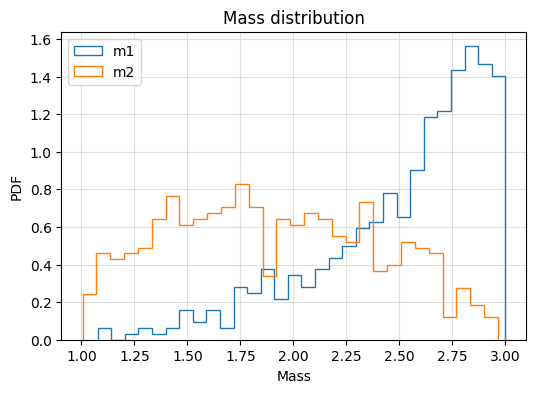

In [58]:
lensed_params = get_param_from_json('ler_data/n_unlensed_detectable_bns_uniformL1.json')
m1 = lensed_params['mass_1_source']
m2 = lensed_params['mass_2_source']

# plot the mass distribution
plt.figure(figsize=(6,4))
plt.hist(m1, bins=30, histtype='step', label='m1', density=True)
plt.hist(m2, bins=30, histtype='step', label='m2', density=True)
plt.xlabel('Mass')
plt.ylabel('PDF')
plt.legend()
plt.title('Mass distribution')
plt.grid(alpha=0.4)
plt.show()

In [49]:
# let's see how rate varies with sampling size
meta_data = get_param_from_json('ler_data/n_lensed_detectable_bns_uniformL1_meta.json')
meta_data.keys()

dict_keys(['events_total', 'detectable_events', 'total_rate'])

In [50]:
# getting data from json
lensed_params_detectable = get_param_from_json("ler_data/n_lensed_detectable_bns_uniformL1.json")

snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
mu = lensed_params_detectable['magnifications'].flatten()
mu_arr1 = abs(mu[np.where(snr_l>8)[0]])

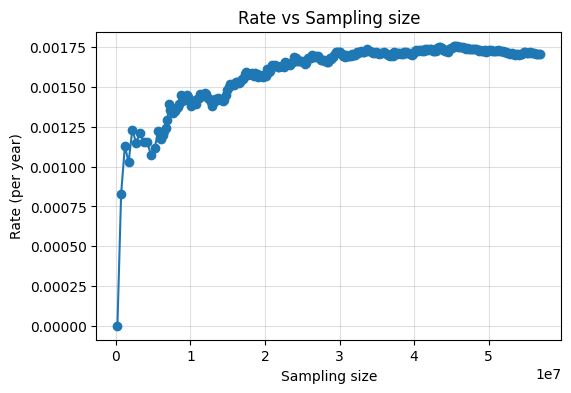

In [51]:
# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [54]:
# getting data from json
lensed_params_detectable = get_param_from_json("ler_data/n_lensed_detectable_bns.json")

snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
mu = lensed_params_detectable['magnifications'].flatten()
mu_arr2 = abs(mu[np.where(snr_l>8)[0]])

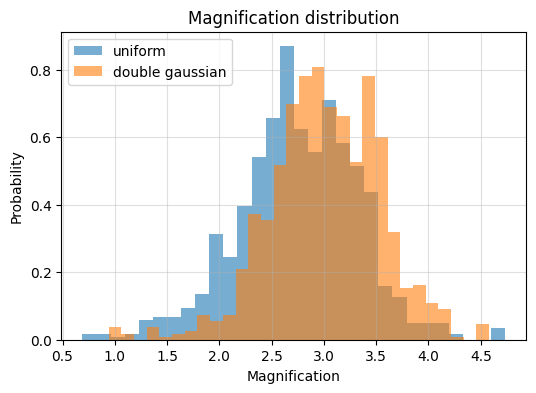

In [55]:
# plot histogram
plt.figure(figsize=(6,4))
mu_arr_1 = mu_arr1[mu_arr1<2000]
mu_arr_2 = mu_arr2[mu_arr2<2000]

plt.hist(np.log10(mu_arr1), bins=30, alpha=0.6, density=True, label='uniform')
plt.hist(np.log10(mu_arr2), bins=30, alpha=0.6, density=True, label='double gaussian')
# plt.hist(mu_arr_1, bins=30, alpha=0.6, density=True, label='uniform')
# plt.hist(mu_arr_2, bins=30, alpha=0.6, density=True, label='double gaussian')
plt.xlabel('Magnification')
plt.ylabel('Probability')
# plt.xscale('log')
plt.title('Magnification distribution')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

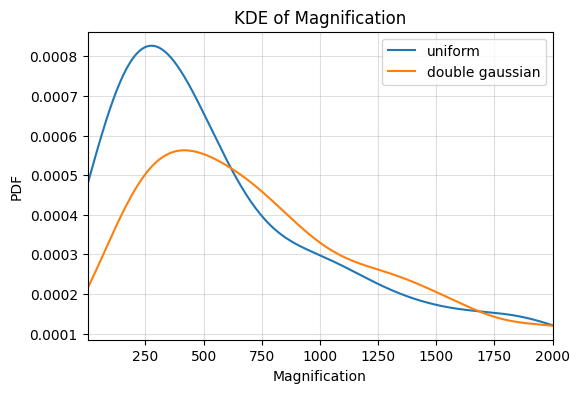

In [56]:
# find kde of magnification
from scipy.stats import gaussian_kde

kde1 = gaussian_kde(mu_arr1, bw_method=0.05)
kde2 = gaussian_kde(mu_arr2, bw_method=0.05)
x = np.linspace(0, 2000, 1000)
plt.figure(figsize=(6,4))
plt.plot(x, kde1(x), label='uniform')
plt.plot(x, kde2(x), label='double gaussian')
plt.xlabel('Magnification')
plt.ylabel('PDF')
#plt.xscale('log')
plt.xlim(1, 2000)
plt.title('KDE of Magnification')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

In [57]:
# find the peak in the kde
from scipy.signal import find_peaks

peaks1, _ = find_peaks(kde1(x))
peaks2, _ = find_peaks(kde2(x))

print('Peak in uniform:', x[peaks1][0])
print('Peak in double gaussian:', x[peaks2][0])

Peak in uniform: 276.2762762762763
Peak in double gaussian: 418.41841841841847


In [72]:
from gwsnr import GWSNR

snr = GWSNR(npool=6,
          mtot_max=51,
          psds={'L1':'custom_psd.txt'},
          snr_type="interpolation",
          )

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  6
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 51
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='custom_psd.txt', asd_file='None')]
min(ratio):  0.1
max(ratio):  1.0
mtot resolution:  500
ratio resolution:  50
interpolator directory:  ./interpolator_pickle


In [ ]:
ans = snr.snr(mass_1=np.array([1,2,3]), mass_2=np.array([1,2,3]))
print(ans.keys())
print(ans['optimal_snr_net']-ans['L1'])

dict_keys(['L1', 'optimal_snr_net'])
[0. 0. 0.]


In [ ]:
ans['optimal_snr_net']

array([15.73340345, 27.54959692, 38.00226742])

In [ ]:
import gwsnr
gwsnr.__version__

'0.2.4'

In [1]:
from ler.rates import LeR

ler = LeR(npool=8,
          verbose=False, 
          event_type='BNS', 
          mtot_max=51,  # for SNR interpolation
          z_max=1,
          psds={'L1':'custom_psd.txt'},
          snr_type="interpolation",
          source_priors=dict(source_frame_masses='binary_masses_uniform',),
          source_priors_params=dict(
              source_frame_masses=dict(
                  m_min=1,
                  m_max=3,
              ),
          ),
          )

In [10]:
# snr_cut=8.0
# time will take long time sample
ler.selecting_n_lensed_detectable_events(size=500, batch_size=200000,snr_threshold=8.0, num_img=1, output_jsonfile='n_lensed_detectable_bns_uniformL1_zs1.json', meta_data_file='n_lensed_detectable_bns_uniformL1_zs1_meta.json', resume=True);

collected number of detectable events =  142.0


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  198.0
total number of events =  800000
total lensed rate (yr^-1): 0.00032347669150391197


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  246.0
total number of events =  1000000
total lensed rate (yr^-1): 0.0003215162267069185


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  296.0
total number of events =  1200000
total lensed rate (yr^-1): 0.00032238754439447117


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  350.0
total number of events =  1400000
total lensed rate (yr^-1): 0.0003267441328322343


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


collected number of events =  409.0
total number of events =  1600000
total lensed rate (yr^-1): 0.0003340958758209596


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


collected number of events =  460.0
total number of events =  1800000
total lensed rate (yr^-1): 0.0003340051135618395


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.88it/s]


collected number of events =  515.0
total number of events =  2000000
total lensed rate (yr^-1): 0.0003365464568172013
storing detectable lensed params in ./ler_data/n_lensed_detectable_bns_uniformL1_zs1.json

 trmming final result to size=500


In [1]:
from ler.utils import get_param_from_json
import numpy as np
# getting data from json
lensed_params_detectable = get_param_from_json("ler_data/n_lensed_detectable_bns_uniformL1_zs1.json")

snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
mu = lensed_params_detectable['magnifications'].flatten()
mu_arr2 = abs(mu[np.where(snr_l>8)[0]])

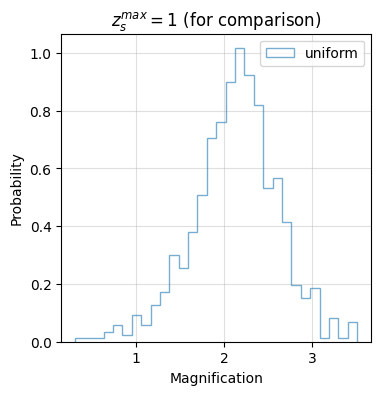

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.hist(np.log10(mu_arr2), bins=30, alpha=0.6, density=True, label='uniform', histtype='step')
plt.xlabel('Magnification')
plt.ylabel('Probability')
plt.title(r'$z_s^{max}=1$ (for comparison)')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

In [1]:
from ler.rates import LeR

ler = LeR(npool=8,
          verbose=False, 
          event_type='BNS', 
          mtot_max=51,  # for SNR interpolation
          z_max=5,
          psds={'L1':'custom_psd.txt'},
          snr_type="interpolation",
          source_priors=dict(source_frame_masses='binary_masses_uniform',),
          source_priors_params=dict(
              source_frame_masses=dict(
                  m_min=1,
                  m_max=3,
              ),
          lens_priors=dict(
            velocity_dispersion="velocity_dispersion_gengamma",
            ),
          lens_priors_params=dict(
            velocity_dispersion=dict(a=2.32 / 2.67, c=2.67, vd_min=10, vd_max=350),
            ),
          ),
          )

In [2]:
# snr_cut=8.0
ler.selecting_n_unlensed_detectable_events(size=1000, batch_size=200000,snr_threshold=8.0, output_jsonfile='n_unlensed_detectable_bns_uniformL1_new.json', meta_data_file='n_unlensed_detectable_bns_uniformL1_new_meta.json', resume=False);

collected number of detectable events =  0
collected number of detectable events =  1
total number of events =  200000
total unlensed rate (yr^-1): 0.46801871728052974
collected number of detectable events =  3
total number of events =  400000
total unlensed rate (yr^-1): 0.7020280759207946
collected number of detectable events =  4
total number of events =  600000
total unlensed rate (yr^-1): 0.6240249563740397
collected number of detectable events =  5
total number of events =  800000
total unlensed rate (yr^-1): 0.5850233966006622
collected number of detectable events =  6
total number of events =  1000000
total unlensed rate (yr^-1): 0.5616224607366357
collected number of detectable events =  9
total number of events =  1200000
total unlensed rate (yr^-1): 0.7020280759207946
collected number of detectable events =  11
total number of events =  1400000
total unlensed rate (yr^-1): 0.7354579842979753
collected number of detectable events =  13
total number of events =  1600000
total 

In [55]:
# snr_cut=8.0
# time will take long time sample
ler.selecting_n_lensed_detectable_events(size=1000, batch_size=200000,snr_threshold=8.0, num_img=1,output_jsonfile='n_lensed_detectable_bns_uniformL1_new.json', meta_data_file='n_lensed_detectable_bns_uniformL1_new_meta.json', resume=True);

collected number of detectable events =  621.0


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  624.0
total number of events =  70000000
total lensed rate (yr^-1): 0.0015775308162562277


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  625.0
total number of events =  70200000
total lensed rate (yr^-1): 0.0015755573181754046


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  625.0
total number of events =  70400000
total lensed rate (yr^-1): 0.001571081303066952


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  628.0
total number of events =  70600000
total lensed rate (yr^-1): 0.001574150474926994


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  630.0
total number of events =  70800000
total lensed rate (yr^-1): 0.0015747027786130045


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  630.0
total number of events =  71000000
total lensed rate (yr^-1): 0.0015702669961380382


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  633.0
total number of events =  71200000
total lensed rate (yr^-1): 0.001573312591569285


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.75it/s]


collected number of events =  635.0
total number of events =  71400000
total lensed rate (yr^-1): 0.0015738626010600564


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


collected number of events =  635.0
total number of events =  71600000
total lensed rate (yr^-1): 0.0015694663368112853


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  638.0
total number of events =  71800000
total lensed rate (yr^-1): 0.0015724887118331533


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]


collected number of events =  638.0
total number of events =  72000000
total lensed rate (yr^-1): 0.0015681206876336168


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  639.0
total number of events =  72200000
total lensed rate (yr^-1): 0.0015662279239279484


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  640.0
total number of events =  72400000
total lensed rate (yr^-1): 0.0015643456174803223


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


collected number of events =  641.0
total number of events =  72600000
total lensed rate (yr^-1): 0.0015624736818671183


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


collected number of events =  644.0
total number of events =  72800000
total lensed rate (yr^-1): 0.001565473751339082


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of events =  646.0
total number of events =  73000000
total lensed rate (yr^-1): 0.0015660331821019191


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.03it/s]


collected number of events =  648.0
total number of events =  73200000
total lensed rate (yr^-1): 0.0015665895558660521


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.67it/s]


collected number of events =  648.0
total number of events =  73400000
total lensed rate (yr^-1): 0.0015623209194740467


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


collected number of events =  653.0
total number of events =  73600000
total lensed rate (yr^-1): 0.0015700976695554663


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  654.0
total number of events =  73800000
total lensed rate (yr^-1): 0.001568240583702707


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  656.0
total number of events =  74000000
total lensed rate (yr^-1): 0.0015687849766650636


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


collected number of events =  656.0
total number of events =  74200000
total lensed rate (yr^-1): 0.0015645564457306565


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.86it/s]


collected number of events =  657.0
total number of events =  74400000
total lensed rate (yr^-1): 0.0015627292321396798


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


collected number of events =  660.0
total number of events =  74600000
total lensed rate (yr^-1): 0.001565656228755021


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  661.0
total number of events =  74800000
total lensed rate (yr^-1): 0.001563835845763396


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


collected number of events =  665.0
total number of events =  75000000
total lensed rate (yr^-1): 0.0015691038354001582


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


collected number of events =  666.0
total number of events =  75200000
total lensed rate (yr^-1): 0.0015672839661301772


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  668.0
total number of events =  75400000
total lensed rate (yr^-1): 0.0015678207884475364


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.82it/s]


collected number of events =  671.0
total number of events =  75600000
total lensed rate (yr^-1): 0.001570695598450749


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


collected number of events =  673.0
total number of events =  75800000
total lensed rate (yr^-1): 0.0015712205862642684


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of events =  674.0
total number of events =  76000000
total lensed rate (yr^-1): 0.0015694143031159081


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  675.0
total number of events =  76200000
total lensed rate (yr^-1): 0.0015676175017688514


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  678.0
total number of events =  76400000
total lensed rate (yr^-1): 0.0015704627412135978


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s]


collected number of events =  680.0
total number of events =  76600000
total lensed rate (yr^-1): 0.001570982854108013


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  681.0
total number of events =  76800000
total lensed rate (yr^-1): 0.0015691960055032714


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  681.0
total number of events =  77000000
total lensed rate (yr^-1): 0.0015651201717227434


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


collected number of events =  682.0
total number of events =  77200000
total lensed rate (yr^-1): 0.0015633577696972632


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


collected number of events =  685.0
total number of events =  77400000
total lensed rate (yr^-1): 0.0015661772560020813


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


collected number of events =  686.0
total number of events =  77600000
total lensed rate (yr^-1): 0.001564421214079105


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


collected number of events =  689.0
total number of events =  77800000
total lensed rate (yr^-1): 0.001567223470520192


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  690.0
total number of events =  78000000
total lensed rate (yr^-1): 0.001565473751339082


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  694.0
total number of events =  78200000
total lensed rate (yr^-1): 0.001570521982050617


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  694.0
total number of events =  78400000
total lensed rate (yr^-1): 0.0015665155484229367


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


collected number of events =  695.0
total number of events =  78600000
total lensed rate (yr^-1): 0.0015647809872052889


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


collected number of events =  696.0
total number of events =  78800000
total lensed rate (yr^-1): 0.0015630552308669185


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]


collected number of events =  699.0
total number of events =  79000000
total lensed rate (yr^-1): 0.0015658183795727284


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


collected number of events =  700.0
total number of events =  79200000
total lensed rate (yr^-1): 0.0015640987194977655


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  701.0
total number of events =  79400000
total lensed rate (yr^-1): 0.001562387722697739


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of events =  703.0
total number of events =  79600000
total lensed rate (yr^-1): 0.0015629085223386357


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


collected number of events =  706.0
total number of events =  79800000
total lensed rate (yr^-1): 0.0015656443379960874


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.77it/s]


collected number of events =  706.0
total number of events =  80000000
total lensed rate (yr^-1): 0.0015617302271510973


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  707.0
total number of events =  80200000
total lensed rate (yr^-1): 0.0015600422041155268


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  709.0
total number of events =  80400000
total lensed rate (yr^-1): 0.0015605636562937833


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


collected number of events =  709.0
total number of events =  80600000
total lensed rate (yr^-1): 0.0015566912899009947


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


collected number of events =  710.0
total number of events =  80800000
total lensed rate (yr^-1): 0.0015550282743069014


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.82it/s]


collected number of events =  713.0
total number of events =  81000000
total lensed rate (yr^-1): 0.0015577430167645681


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


collected number of events =  713.0
total number of events =  81200000
total lensed rate (yr^-1): 0.0015539062113045568


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.16it/s]


collected number of events =  715.0
total number of events =  81400000
total lensed rate (yr^-1): 0.00155443633358581


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  718.0
total number of events =  81600000
total lensed rate (yr^-1): 0.001557132565536977


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


collected number of events =  723.0
total number of events =  81800000
total lensed rate (yr^-1): 0.0015641424246663157


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


collected number of events =  724.0
total number of events =  82000000
total lensed rate (yr^-1): 0.001562485572386367


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


collected number of events =  724.0
total number of events =  82200000
total lensed rate (yr^-1): 0.0015586839043270327


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


collected number of events =  725.0
total number of events =  82400000
total lensed rate (yr^-1): 0.0015570483438550916


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


collected number of events =  727.0
total number of events =  82600000
total lensed rate (yr^-1): 0.001557563156532863


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.25it/s]


collected number of events =  729.0
total number of events =  82800000
total lensed rate (yr^-1): 0.0015580754821928671


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  731.0
total number of events =  83000000
total lensed rate (yr^-1): 0.0015585853388135461


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  733.0
total number of events =  83200000
total lensed rate (yr^-1): 0.0015590927442004716


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


collected number of events =  740.0
total number of events =  83400000
total lensed rate (yr^-1): 0.0015702072242604493


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  742.0
total number of events =  83600000
total lensed rate (yr^-1): 0.0015706843983167033


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.86it/s]


collected number of events =  743.0
total number of events =  83800000
total lensed rate (yr^-1): 0.0015690475214469434


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  743.0
total number of events =  84000000
total lensed rate (yr^-1): 0.001565311694014927


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  744.0
total number of events =  84200000
total lensed rate (yr^-1): 0.001563695355050253


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  747.0
total number of events =  84400000
total lensed rate (yr^-1): 0.0015662801977389064


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


collected number of events =  747.0
total number of events =  84600000
total lensed rate (yr^-1): 0.0015625774076733297


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s]


collected number of events =  749.0
total number of events =  84800000
total lensed rate (yr^-1): 0.0015630658241169648


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


collected number of events =  750.0
total number of events =  85000000
total lensed rate (yr^-1): 0.0015614699821540716


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.12it/s]


collected number of events =  750.0
total number of events =  85200000
total lensed rate (yr^-1): 0.0015578045596607523


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


collected number of events =  751.0
total number of events =  85400000
total lensed rate (yr^-1): 0.0015562285138299011


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  756.0
total number of events =  85600000
total lensed rate (yr^-1): 0.0015629292998944027


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  759.0
total number of events =  85800000
total lensed rate (yr^-1): 0.0015654737513390818


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  760.0
total number of events =  86000000
total lensed rate (yr^-1): 0.0015638908658473338


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.54it/s]


collected number of events =  762.0
total number of events =  86200000
total lensed rate (yr^-1): 0.0015643683023065617


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.64it/s]


collected number of events =  763.0
total number of events =  86400000
total lensed rate (yr^-1): 0.0015627953038981838


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  765.0
total number of events =  86600000
total lensed rate (yr^-1): 0.001563273065274342


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s]


collected number of events =  768.0
total number of events =  86800000
total lensed rate (yr^-1): 0.0015657874106761566


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


collected number of events =  771.0
total number of events =  87000000
total lensed rate (yr^-1): 0.0015682901958692273


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


collected number of events =  774.0
total number of events =  87200000
total lensed rate (yr^-1): 0.0015707815003962748


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  777.0
total number of events =  87400000
total lensed rate (yr^-1): 0.00157326140307194


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s]


collected number of events =  782.0
total number of events =  87600000
total lensed rate (yr^-1): 0.001579770315278252


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]


collected number of events =  786.0
total number of events =  87800000
total lensed rate (yr^-1): 0.001584234009228755


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.87it/s]


collected number of events =  788.0
total number of events =  88000000
total lensed rate (yr^-1): 0.0015846554455254502


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


collected number of events =  789.0
total number of events =  88200000
total lensed rate (yr^-1): 0.0015830685465330735


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]


collected number of events =  790.0
total number of events =  88400000
total lensed rate (yr^-1): 0.0015814888280791235


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


collected number of events =  792.0
total number of events =  88600000
total lensed rate (yr^-1): 0.00158191360720259


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


collected number of events =  794.0
total number of events =  88800000
total lensed rate (yr^-1): 0.001582336472906581


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


collected number of events =  796.0
total number of events =  89000000
total lensed rate (yr^-1): 0.001582757438090554


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.18it/s]


collected number of events =  799.0
total number of events =  89200000
total lensed rate (yr^-1): 0.0015851604460088756


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


collected number of events =  800.0
total number of events =  89400000
total lensed rate (yr^-1): 0.0015835937179191181


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


collected number of events =  806.0
total number of events =  89600000
total lensed rate (yr^-1): 0.0015919093523418964


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  808.0
total number of events =  89800000
total lensed rate (yr^-1): 0.0015923052468350652


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  808.0
total number of events =  90000000
total lensed rate (yr^-1): 0.0015887667907309873


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


collected number of events =  808.0
total number of events =  90200000
total lensed rate (yr^-1): 0.0015852440262282578


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.09it/s]


collected number of events =  808.0
total number of events =  90400000
total lensed rate (yr^-1): 0.0015817368491790804


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.17it/s]


collected number of events =  810.0
total number of events =  90600000
total lensed rate (yr^-1): 0.0015821517037720063


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.88it/s]


collected number of events =  813.0
total number of events =  90800000
total lensed rate (yr^-1): 0.0015845137021550239


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


collected number of events =  815.0
total number of events =  91000000
total lensed rate (yr^-1): 0.0015849206302377041


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


collected number of events =  818.0
total number of events =  91200000
total lensed rate (yr^-1): 0.0015872661967715293


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.92it/s]


collected number of events =  821.0
total number of events =  91400000
total lensed rate (yr^-1): 0.0015896014982439372


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


collected number of events =  823.0
total number of events =  91600000
total lensed rate (yr^-1): 0.0015899946521337421


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.19it/s]


collected number of events =  824.0
total number of events =  91800000
total lensed rate (yr^-1): 0.0015884583522159936


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


collected number of events =  826.0
total number of events =  92000000
total lensed rate (yr^-1): 0.0015888522818411214


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  828.0
total number of events =  92200000
total lensed rate (yr^-1): 0.001589244502444014


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  828.0
total number of events =  92400000
total lensed rate (yr^-1): 0.0015858045792785506


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  831.0
total number of events =  92600000
total lensed rate (yr^-1): 0.0015881127745061606


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  834.0
total number of events =  92800000
total lensed rate (yr^-1): 0.0015904110206164097


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  835.0
total number of events =  93000000
total lensed rate (yr^-1): 0.0015888936485073152


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


collected number of events =  837.0
total number of events =  93200000
total lensed rate (yr^-1): 0.0015892815719649703


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


collected number of events =  838.0
total number of events =  93400000
total lensed rate (yr^-1): 0.0015877731167570953


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  841.0
total number of events =  93600000
total lensed rate (yr^-1): 0.0015900524455026185


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  842.0
total number of events =  93800000
total lensed rate (yr^-1): 0.0015885487792859545


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


collected number of events =  845.0
total number of events =  94000000
total lensed rate (yr^-1): 0.001590816758414414


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  847.0
total number of events =  94200000
total lensed rate (yr^-1): 0.0015911964807527584


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


collected number of events =  847.0
total number of events =  94400000
total lensed rate (yr^-1): 0.0015878253017681126


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


collected number of events =  849.0
total number of events =  94600000
total lensed rate (yr^-1): 0.0015882097429478306


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  852.0
total number of events =  94800000
total lensed rate (yr^-1): 0.0015904592982784512


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  854.0
total number of events =  95000000
total lensed rate (yr^-1): 0.0015908365755026535


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  855.0
total number of events =  95200000
total lensed rate (yr^-1): 0.0015893533746925371


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.23it/s]


collected number of events =  856.0
total number of events =  95400000
total lensed rate (yr^-1): 0.001587876392753742


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  856.0
total number of events =  95600000
total lensed rate (yr^-1): 0.00158455447561409


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


collected number of events =  858.0
total number of events =  95800000
total lensed rate (yr^-1): 0.001584940929693757


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


collected number of events =  858.0
total number of events =  96000000
total lensed rate (yr^-1): 0.0015816389694235616


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


collected number of events =  858.0
total number of events =  96200000
total lensed rate (yr^-1): 0.0015783507387178994


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


collected number of events =  860.0
total number of events =  96400000
total lensed rate (yr^-1): 0.0015787476583051538


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  863.0
total number of events =  96600000
total lensed rate (yr^-1): 0.0015809748866930562


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  865.0
total number of events =  96800000
total lensed rate (yr^-1): 0.0015813647443233898


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  865.0
total number of events =  97000000
total lensed rate (yr^-1): 0.0015781041984588055


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  865.0
total number of events =  97200000
total lensed rate (yr^-1): 0.0015748570704784376


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  868.0
total number of events =  97400000
total lensed rate (yr^-1): 0.0015770739942960628


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.87it/s]


collected number of events =  870.0
total number of events =  97600000
total lensed rate (yr^-1): 0.001577468650004011


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


collected number of events =  870.0
total number of events =  97800000
total lensed rate (yr^-1): 0.001574242742744289


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  871.0
total number of events =  98000000
total lensed rate (yr^-1): 0.001572835784064989


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


collected number of events =  872.0
total number of events =  98200000
total lensed rate (yr^-1): 0.0015714345563782727


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]


collected number of events =  874.0
total number of events =  98400000
total lensed rate (yr^-1): 0.0015718374657754197


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  876.0
total number of events =  98600000
total lensed rate (yr^-1): 0.0015722387406516857


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  878.0
total number of events =  98800000
total lensed rate (yr^-1): 0.001572638390933311


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]


collected number of events =  878.0
total number of events =  99000000
total lensed rate (yr^-1): 0.0015694613436789003


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  880.0
total number of events =  99200000
total lensed rate (yr^-1): 0.0015698649820581258


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


collected number of events =  884.0
total number of events =  99400000
total lensed rate (yr^-1): 0.0015738276922744056


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


collected number of events =  884.0
total number of events =  99600000
total lensed rate (yr^-1): 0.0015706673957035734


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


collected number of events =  886.0
total number of events =  99800000
total lensed rate (yr^-1): 0.0015710661904612309


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  888.0
total number of events =  100000000
total lensed rate (yr^-1): 0.0015714633900398578


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


collected number of events =  889.0
total number of events =  100200000
total lensed rate (yr^-1): 0.001570092870279074


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]


collected number of events =  891.0
total number of events =  100400000
total lensed rate (yr^-1): 0.001570490426274085


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.82it/s]


collected number of events =  891.0
total number of events =  100600000
total lensed rate (yr^-1): 0.001567368178905747


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.50it/s]


collected number of events =  893.0
total number of events =  100800000
total lensed rate (yr^-1): 0.0015677695634312805


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  896.0
total number of events =  101000000
total lensed rate (yr^-1): 0.001569921502849559


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.18it/s]


collected number of events =  898.0
total number of events =  101200000
total lensed rate (yr^-1): 0.001570316254780241


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  899.0
total number of events =  101400000
total lensed rate (yr^-1): 0.0015689642167824244


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


collected number of events =  901.0
total number of events =  101600000
total lensed rate (yr^-1): 0.001569359298993039


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


collected number of events =  901.0
total number of events =  101800000
total lensed rate (yr^-1): 0.0015662760783663337


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  902.0
total number of events =  102000000
total lensed rate (yr^-1): 0.0015649399154477473


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


collected number of events =  906.0
total number of events =  102200000
total lensed rate (yr^-1): 0.0015688036963559695


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]


collected number of events =  910.0
total number of events =  102400000
total lensed rate (yr^-1): 0.0015726523843700188


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


collected number of events =  911.0
total number of events =  102600000
total lensed rate (yr^-1): 0.0015713116058232689


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  912.0
total number of events =  102800000
total lensed rate (yr^-1): 0.0015699760443136656


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  912.0
total number of events =  103000000
total lensed rate (yr^-1): 0.0015669275471402412


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  914.0
total number of events =  103200000
total lensed rate (yr^-1): 0.0015673204510794551


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.19it/s]


collected number of events =  914.0
total number of events =  103400000
total lensed rate (yr^-1): 0.00156428888347582


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.44it/s]


collected number of events =  916.0
total number of events =  103600000
total lensed rate (yr^-1): 0.0015646853643567055


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  918.0
total number of events =  103800000
total lensed rate (yr^-1): 0.001565080317372925


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s]


collected number of events =  920.0
total number of events =  104000000
total lensed rate (yr^-1): 0.001565473751339082


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


collected number of events =  923.0
total number of events =  104200000
total lensed rate (yr^-1): 0.0015675640108752103


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


collected number of events =  926.0
total number of events =  104400000
total lensed rate (yr^-1): 0.0015696462617541122


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  927.0
total number of events =  104600000
total lensed rate (yr^-1): 0.0015683368673528372


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


collected number of events =  929.0
total number of events =  104800000
total lensed rate (yr^-1): 0.0015687210832162374


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


collected number of events =  931.0
total number of events =  105000000
total lensed rate (yr^-1): 0.0015691038354001582


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  934.0
total number of events =  105200000
total lensed rate (yr^-1): 0.0015711673242485647


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  934.0
total number of events =  105400000
total lensed rate (yr^-1): 0.001568185982077315


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  935.0
total number of events =  105600000
total lensed rate (yr^-1): 0.0015668917529254398


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


collected number of events =  937.0
total number of events =  105800000
total lensed rate (yr^-1): 0.0015672750690442475


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  940.0
total number of events =  106000000
total lensed rate (yr^-1): 0.0015693264348944694


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  942.0
total number of events =  106200000
total lensed rate (yr^-1): 0.0015697037221729631


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  943.0
total number of events =  106400000
total lensed rate (yr^-1): 0.0015684163711724261


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  944.0
total number of events =  106600000
total lensed rate (yr^-1): 0.001567133850757257


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]


collected number of events =  946.0
total number of events =  106800000
total lensed rate (yr^-1): 0.0015675131244071022


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


collected number of events =  947.0
total number of events =  107000000
total lensed rate (yr^-1): 0.001566237086772486


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


collected number of events =  947.0
total number of events =  107200000
total lensed rate (yr^-1): 0.0015633150026553731


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


collected number of events =  950.0
total number of events =  107400000
total lensed rate (yr^-1): 0.0015653470025939328


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


collected number of events =  951.0
total number of events =  107600000
total lensed rate (yr^-1): 0.0015640821066595337


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.76it/s]


collected number of events =  951.0
total number of events =  107800000
total lensed rate (yr^-1): 0.0015611802845692563


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


collected number of events =  952.0
total number of events =  108000000
total lensed rate (yr^-1): 0.0015599277895791046


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.86it/s]


collected number of events =  954.0
total number of events =  108200000
total lensed rate (yr^-1): 0.0015603154756977655


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  954.0
total number of events =  108400000
total lensed rate (yr^-1): 0.0015574366648569947


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  956.0
total number of events =  108600000
total lensed rate (yr^-1): 0.0015578275107408209


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s]


collected number of events =  958.0
total number of events =  108800000
total lensed rate (yr^-1): 0.0015582169196912507


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  960.0
total number of events =  109000000
total lensed rate (yr^-1): 0.001558604899618009


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]


collected number of events =  961.0
total number of events =  109200000
total lensed rate (yr^-1): 0.0015573708851313228


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  962.0
total number of events =  109400000
total lensed rate (yr^-1): 0.0015561413825806024


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  965.0
total number of events =  109600000
total lensed rate (yr^-1): 0.0015581456847468093


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]


collected number of events =  966.0
total number of events =  109800000
total lensed rate (yr^-1): 0.0015569192499656442


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


collected number of events =  967.0
total number of events =  110000000
total lensed rate (yr^-1): 0.00155569727494732


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.45it/s]


collected number of events =  971.0
total number of events =  110200000
total lensed rate (yr^-1): 0.0015592973378957809


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


collected number of events =  972.0
total number of events =  110400000
total lensed rate (yr^-1): 0.0015580754821928671


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  974.0
total number of events =  110600000
total lensed rate (yr^-1): 0.001558458105154136


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


collected number of events =  977.0
total number of events =  110800000
total lensed rate (yr^-1): 0.001560436518266966


100%|███████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.29it/s]


collected number of events =  978.0
total number of events =  111000000
total lensed rate (yr^-1): 0.0015592192146122279


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]


collected number of events =  979.0
total number of events =  111200000
total lensed rate (yr^-1): 0.0015580062897476146


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


collected number of events =  981.0
total number of events =  111400000
total lensed rate (yr^-1): 0.0015583862891911102


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


collected number of events =  982.0
total number of events =  111600000
total lensed rate (yr^-1): 0.0015571792044253327


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


collected number of events =  985.0
total number of events =  111800000
total lensed rate (yr^-1): 0.0015591422093720888


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.28it/s]


collected number of events =  986.0
total number of events =  112000000
total lensed rate (yr^-1): 0.001557938085765866


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


collected number of events =  988.0
total number of events =  112200000
total lensed rate (yr^-1): 0.0015583154973416392


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


collected number of events =  989.0
total number of events =  112400000
total lensed rate (yr^-1): 0.001557117129890653


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.52it/s]


collected number of events =  989.0
total number of events =  112600000
total lensed rate (yr^-1): 0.001554351380103991


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


collected number of events =  990.0
total number of events =  112800000
total lensed rate (yr^-1): 0.001553164290759635


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


collected number of events =  992.0
total number of events =  113000000
total lensed rate (yr^-1): 0.00155354747958975


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]


collected number of events =  993.0
total number of events =  113200000
total lensed rate (yr^-1): 0.0015523660052263182


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.00it/s]


collected number of events =  994.0
total number of events =  113400000
total lensed rate (yr^-1): 0.0015511886983209586


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.03it/s]


collected number of events =  996.0
total number of events =  113600000
total lensed rate (yr^-1): 0.0015515733414221092


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.14it/s]


collected number of events =  997.0
total number of events =  113800000
total lensed rate (yr^-1): 0.0015504015657603607


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


collected number of events =  1003.0
total number of events =  114000000
total lensed rate (yr^-1): 0.0015569955944859108
storing detectable lensed params in ./ler_data/n_lensed_detectable_bns_uniformL1_new.json

 trmming final result to size=1000


In [5]:
from ler.utils import get_param_from_json
import numpy as np
import matplotlib.pyplot as plt
# getting data from json
lensed_params_detectable = get_param_from_json("ler_data/n_lensed_detectable_bns_uniformL1_new.json")

snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
mu = lensed_params_detectable['magnifications'].flatten()
mu_arr2 = abs(mu[np.where(snr_l>8)[0]])

In [54]:
mu = lensed_params_detectable['magnifications']
dt = lensed_params_detectable['time_delays']

dt12 = dt[:,1]-dt[:,0]
mu1 = abs(mu[:,0])
mu2 = abs(mu[:,1])

# check nan values in mu
idx_nan = (~np.isnan(mu2)) & (~np.isnan(mu1))
snr1 = lensed_params_detectable['optimal_snr_net'][:,0]
snr2 = lensed_params_detectable['optimal_snr_net'][:,1]
# idx_snr8 = (snr1>8) | (snr2>8)
# idx_snr4 = (snr1>4) & (snr2>4)
# idx_snr = idx_snr8 & idx_snr4
idx_snr = (snr1>8) & (snr2>8)
idx = idx_nan & idx_snr

dt12 = dt12[idx]
mu1 = mu1[idx]
mu2 = mu2[idx]

mu1_12 = mu1
mu2_12 = mu2

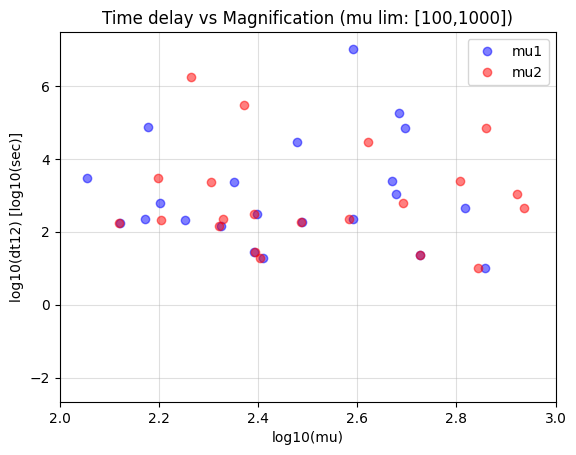

In [55]:
plt.plot(np.log10(mu1), np.log10(dt12), 'o', alpha=0.5, color='b', label='mu1')
plt.plot(np.log10(mu2), np.log10(dt12), 'o', alpha=0.5, color='r', label='mu2')
plt.xlabel('log10(mu)')
plt.ylabel('log10(dt12) [log10(sec)]')
plt.title('Time delay vs Magnification (mu lim: [100,1000])')
plt.legend()
plt.xlim(2.0, 3.0)
#plt.ylim(-2.0, 2.0)
plt.grid(alpha=0.4)
plt.show()

In [63]:
mu = lensed_params_detectable['magnifications']
dt = lensed_params_detectable['time_delays']

dt13 = dt[:,2]-dt[:,0]
mu1 = abs(mu[:,0])
mu3 = abs(mu[:,2])

# check nan values in mu
idx_nan = (~np.isnan(mu3)) & (~np.isnan(mu1))
# check snr>8
snr1 = lensed_params_detectable['optimal_snr_net'][:,0]
snr3 = lensed_params_detectable['optimal_snr_net'][:,2]
# idx_snr8 = (snr1>8) | (snr3>8)
# idx_snr4 = (snr1>4) & (snr3>4)
# idx_snr = idx_snr8 & idx_snr4
idx_snr = (snr1>8) & (snr3>8)
idx = idx_nan & idx_snr
dt13 = dt13[idx]
mu1 = mu1[idx]
mu3 = mu3[idx]

mu1_13 = mu1
mu3_13 = mu3

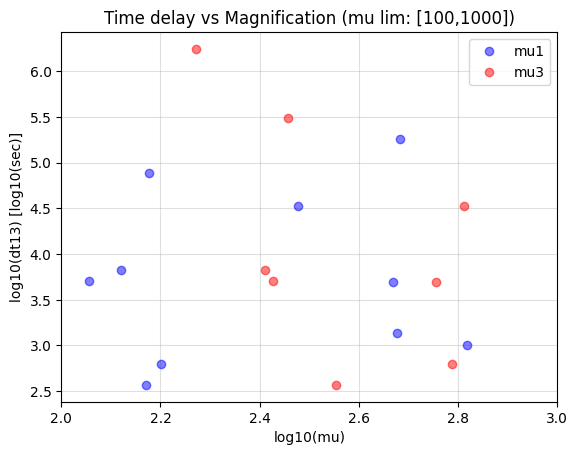

In [64]:
# plot
plt.plot(np.log10(mu1), np.log10(dt13), 'o', alpha=0.5, color='b', label='mu1')
plt.plot(np.log10(mu3), np.log10(dt13), 'o', alpha=0.5, color='r', label='mu3')
plt.xlabel('log10(mu)')
plt.ylabel('log10(dt13) [log10(sec)]')
plt.title('Time delay vs Magnification (mu lim: [100,1000])')
plt.legend()
plt.xlim(2.0, 3.0)
#plt.ylim(-2.0, 2.0)
plt.grid(alpha=0.4)
plt.show()

In [65]:
mu = lensed_params_detectable['magnifications']
dt = lensed_params_detectable['time_delays']

dt14 = dt[:,3]-dt[:,0]
mu1 = abs(mu[:,0])
mu4 = abs(mu[:,3])

# check nan values in mu
idx_nan = (~np.isnan(mu4)) & (~np.isnan(mu1))
snr1 = lensed_params_detectable['optimal_snr_net'][:,0]
snr4 = lensed_params_detectable['optimal_snr_net'][:,3]
# idx_snr8 = (snr1>8) | (snr4>8)
# idx_snr4 = (snr1>4) & (snr4>4)
# idx_snr = idx_snr8 & idx_snr4
idx_snr = (snr1>8) & (snr4>8)
idx = idx_nan & idx_snr
dt14 = dt14[idx]
mu1 = mu1[idx]
mu4 = mu4[idx]

mu1_14 = mu1
mu4_14 = mu4

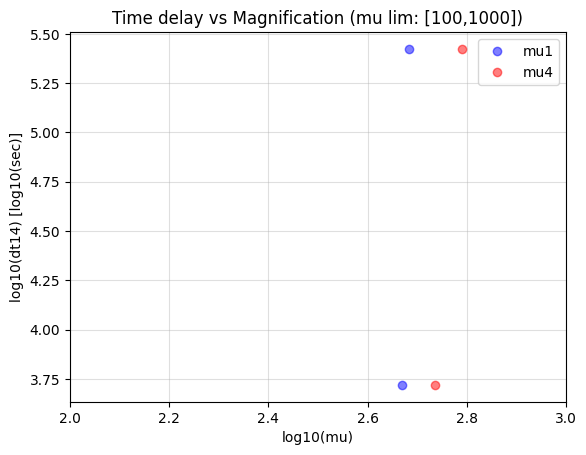

In [67]:
# plot
plt.plot(np.log10(mu1), np.log10(dt14), 'o', alpha=0.5, color='b', label='mu1')
plt.plot(np.log10(mu4), np.log10(dt14), 'o', alpha=0.5, color='r', label='mu4')
plt.xlabel('log10(mu)')
plt.ylabel('log10(dt14) [log10(sec)]')
plt.title('Time delay vs Magnification (mu lim: [100,1000])')
plt.legend()
plt.xlim(2.0, 3.0)
#plt.ylim(-2.0, 2.0)
plt.grid(alpha=0.4)
plt.show()

In [68]:
mu = lensed_params_detectable['magnifications']
dt = lensed_params_detectable['time_delays']

dt23 = dt[:,2]-dt[:,1]
mu2 = abs(mu[:,1])
mu3 = abs(mu[:,2])

# check nan values in mu
idx_nan = (~np.isnan(mu3)) & (~np.isnan(mu2))
snr3 = lensed_params_detectable['optimal_snr_net'][:,2]
snr2 = lensed_params_detectable['optimal_snr_net'][:,1]
# idx_snr8 = (snr2>8) | (snr3>8)
# idx_snr4 = (snr2>4) & (snr3>4)
# idx_snr = idx_snr8 & idx_snr4
idx_snr = (snr2>8) & (snr3>8)
idx = idx_nan & idx_snr
dt23 = dt23[idx]
mu2 = mu2[idx]
mu3 = mu3[idx]

mu2_23 = mu2
mu3_23 = mu3

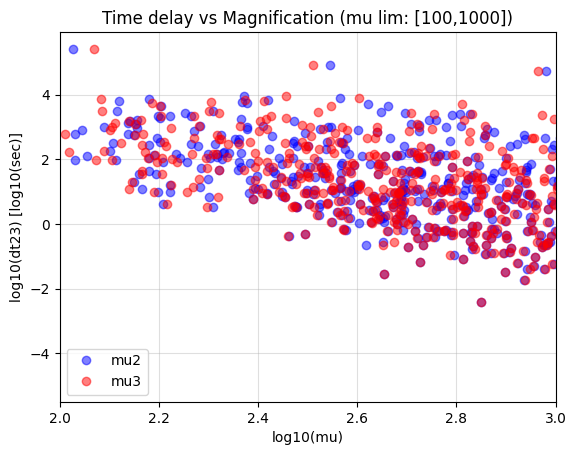

In [69]:
# plot  
plt.plot(np.log10(mu2), np.log10(dt23), 'o', alpha=0.5, color='b', label='mu2')
plt.plot(np.log10(mu3), np.log10(dt23), 'o', alpha=0.5, color='r', label='mu3')
plt.xlabel('log10(mu)')
plt.ylabel('log10(dt23) [log10(sec)]')
plt.title('Time delay vs Magnification (mu lim: [100,1000])')
plt.legend()
plt.xlim(2.0, 3.0)
#plt.ylim(-2.0, 2.0)
plt.grid(alpha=0.4)
plt.show()

In [70]:
mu = lensed_params_detectable['magnifications']
dt = lensed_params_detectable['time_delays']

dt24 = dt[:,3]-dt[:,1]
mu2 = abs(mu[:,1])
mu4 = abs(mu[:,3])

# check nan values in mu
idx_nan = (~np.isnan(mu4)) & (~np.isnan(mu2))
snr4 = lensed_params_detectable['optimal_snr_net'][:,3]
snr2 = lensed_params_detectable['optimal_snr_net'][:,1]
# idx_snr8 = (snr2>8) | (snr4>8)
# idx_snr4 = (snr2>4) & (snr4>4)
# idx_snr = idx_snr8 & idx_snr4
idx_snr = (snr2>8) & (snr4>8)
idx = idx_nan & idx_snr
dt24 = dt24[idx]
mu2 = mu2[idx]
mu4 = mu4[idx]

mu2_24 = mu2
mu4_24 = mu4

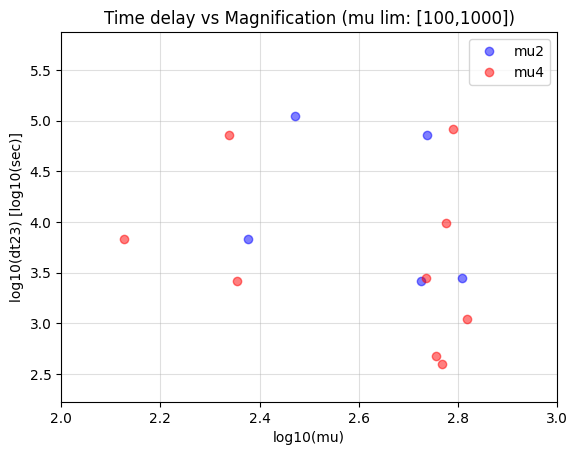

In [71]:
# plot  
plt.plot(np.log10(mu2), np.log10(dt24), 'o', alpha=0.5, color='b', label='mu2')
plt.plot(np.log10(mu4), np.log10(dt24), 'o', alpha=0.5, color='r', label='mu4')
plt.xlabel('log10(mu)')
plt.ylabel('log10(dt23) [log10(sec)]')
plt.title('Time delay vs Magnification (mu lim: [100,1000])')
plt.legend()
plt.xlim(2.0, 3.0)
plt.grid(alpha=0.4)
plt.show()

In [72]:
mu = lensed_params_detectable['magnifications']
dt = lensed_params_detectable['time_delays']

dt34 = dt[:,3]-dt[:,2]
mu3 = abs(mu[:,2])
mu4 = abs(mu[:,3])

# check nan values in mu
idx_nan = (~np.isnan(mu4)) & (~np.isnan(mu3))
snr3 = lensed_params_detectable['optimal_snr_net'][:,2]
snr4 = lensed_params_detectable['optimal_snr_net'][:,3]
# idx_snr8 = (snr3>8) | (snr4>8)
# idx_snr4 = (snr3>4) & (snr4>4)
# idx_snr = idx_snr8 & idx_snr4
idx_snr = (snr3>8) & (snr4>8)
idx = idx_nan & idx_snr
dt34 = dt34[idx]
mu3 = mu3[idx]
mu4 = mu4[idx]

mu3_34 = mu3
mu4_34 = mu4

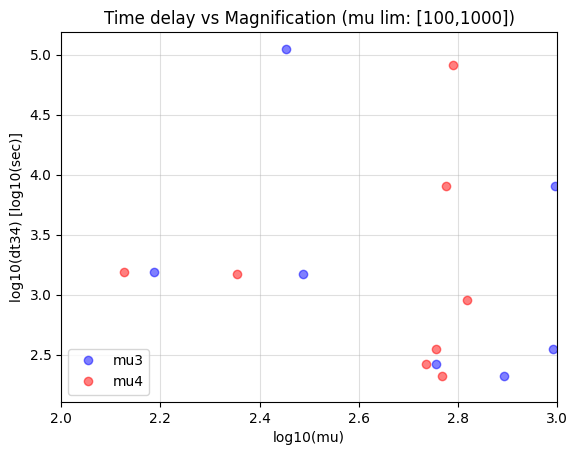

In [73]:
# plot
plt.plot(np.log10(mu3), np.log10(dt34), 'o', alpha=0.5, color='b', label='mu3')
plt.plot(np.log10(mu4), np.log10(dt34), 'o', alpha=0.5, color='r', label='mu4')
plt.xlabel('log10(mu)')
plt.ylabel('log10(dt34) [log10(sec)]')
plt.title('Time delay vs Magnification (mu lim: [100,1000])')
plt.legend()
plt.xlim(2.0, 3.0)
plt.grid(alpha=0.4)
plt.show()

In [74]:
dt_all = np.concatenate([dt12, dt12, dt13, dt13, dt14, dt14, dt23, dt23, dt24, dt24, dt34, dt34])
mu_all = np.concatenate([mu1_12, mu2_12, mu1_13, mu3_13, mu1_14, mu4_14, mu2_23, mu3_23, mu2_24, mu4_24, mu3_34, mu4_34])

In [75]:
np.shape(dt_all), np.shape(mu_all)

((1586,), (1586,))

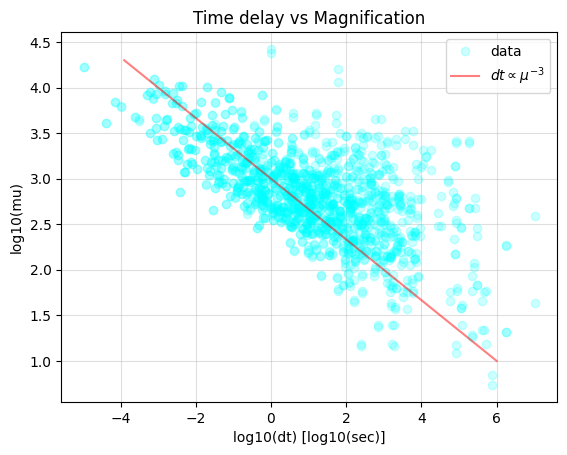

In [127]:
# plot dt\propto mu^-3 relation
mu_ = np.linspace(1000, 20000, 1000)
constant = 1000000000
dt_ = constant*mu_**-3
len(mu_), len(dt_)

# plot
plt.plot(np.log10(dt_all), np.log10(mu_all), 'o', alpha=0.2, color='cyan', label='data')
plt.plot(np.log10(dt_), np.log10(mu_), alpha=0.5, color='r', label=r'$dt\propto \mu^{-3}$')
plt.legend()
plt.ylabel('log10(mu)')
plt.xlabel('log10(dt) [log10(sec)]')
plt.title('Time delay vs Magnification')
plt.grid(alpha=0.4)

plt.show()

In [129]:
# fit the data to the power law
from scipy.optimize import curve_fit

def func(log10_mu, a):
    mu = 10**log10_mu
    return np.log10(a*mu**-3)

mu_for_fit = np.log10(mu_all[mu_all>1000])
dt_for_fit = np.log10(dt_all[mu_all>1000])
popt, pcov = curve_fit(func, mu_for_fit, dt_for_fit)
popt

array([6.08542622e+09])

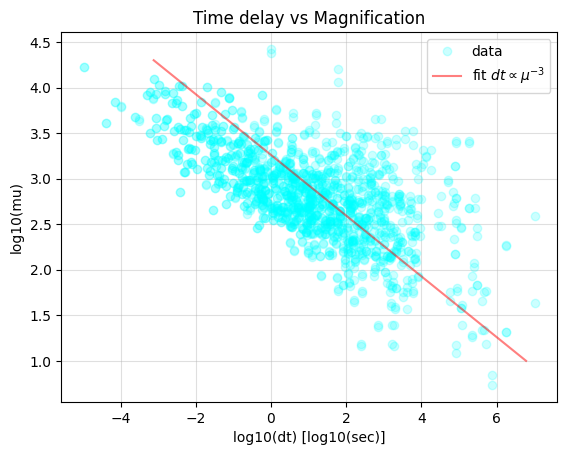

In [130]:
# plot with fit
plt.plot(np.log10(dt_all), np.log10(mu_all), 'o', alpha=0.2, color='cyan', label='data')
# plt.plot(np.log10(dt_), np.log10(mu_), alpha=0.5, color='r', label=r'$dt\propto \mu^{-3}$')
plt.plot(func(np.log10(mu_), *popt), np.log10(mu_), alpha=0.5, color='r', label=r'fit $dt\propto \mu^{-3}$')
plt.legend()
plt.ylabel('log10(mu)')
plt.xlabel('log10(dt) [log10(sec)]')
plt.title('Time delay vs Magnification')
plt.grid(alpha=0.4)

plt.show()

In [77]:
# make a kde and plot contour
from scipy.stats import gaussian_kde

x = np.log10(dt_all)
y = np.log10(mu_all)

# Perform a kernel density estimation (KDE)
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels1 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(x), max(x), 1000)
ygrid = np.linspace(min(y), max(y), 1000)
X1, Y1 = np.meshgrid(xgrid, ygrid)
Z1 = gaussian_kde(xy)(np.vstack([X1.ravel(), Y1.ravel()])).reshape(X1.shape)

In [133]:
popt

array([6.08542622e+09])

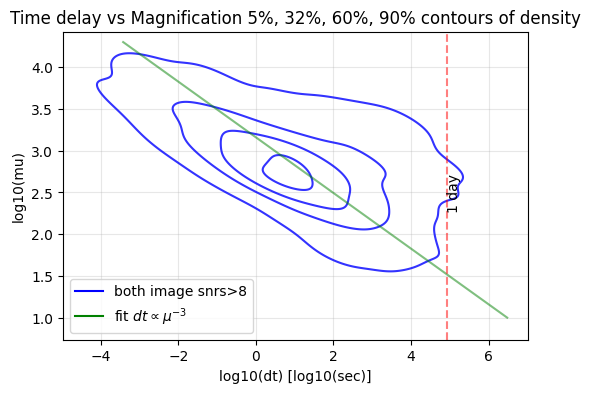

In [137]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels1, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.plot(func(np.log10(mu_), 3.02e9), np.log10(mu_), alpha=0.5, color='g', label=r'fit $dt\propto \mu^{-3}$')
# plt.plot(func(np.log10(mu_), *popt), np.log10(mu_), alpha=0.5, color='magenta', label=r'fit $dt\propto \mu^{-3}$')
plt.ylabel('log10(mu)')
plt.xlabel('log10(dt) [log10(sec)]')
plt.title('Time delay vs Magnification 5%, 32%, 60%, 90% contours of density')
# plt.colorbar(contour1, label='Density')
# plt.xlim(-5, 6)
# plt.ylim(1.5, 4.5)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='blue', label='both image snrs>8')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='g', label='fit $dt\propto \mu^{-3}$')
plt.legend(handles=[proxy1, proxy2])

# include vertical lines that shows log10(1 day) and log10(10 days) and log10(100 days)
# also write labels 1day and 10 days and 100 days, vertically
# convert seconds to days
plt.axvline(np.log10(24*3600), color='r', linestyle='--', alpha=0.5)
# plt.axvline(np.log10(10*24*3600), color='r', linestyle='--', alpha=0.5)
# plt.axvline(np.log10(100*24*3600), color='r', linestyle='--', alpha=0.5)
plt.text(np.log10(24*3600), 2.5, '1 day', rotation=90, verticalalignment='center')
# plt.text(np.log10(10*24*3600), 2.5, '10 days', rotation=90, verticalalignment='center')
# plt.text(np.log10(100*24*3600), 2.5, '100 days', rotation=90, verticalalignment='center')

plt.show()

In [ ]:
{[dt12, mu1], [dt12, mu2], [dt13, mu1], [dt13, mu3], [dt14, mu1], [dt14, mu4], [dt23, mu2], [dt23, mu3], [dt24, mu2], [dt24, mu4], [dt34, mu3], [dt34, mu4]}

In [218]:
dt = lensed_params_detectable['time_delays']

dt34 = (dt[:,3]-dt[:,2])/86400
idx_nan = ~np.isnan(dt34)
snr3 = lensed_params_detectable['optimal_snr_net'][:,2]
snr4 = lensed_params_detectable['optimal_snr_net'][:,3]
idx_snr8 = (snr3>8) | (snr4>8)
idx_snr4 = (snr3>4) & (snr4>4)
idx_snr = idx_snr8 & idx_snr4
idx = idx_nan & idx_snr
dt34 = dt34[idx]

dt24 = (dt[:,3]-dt[:,1])/86400
idx_nan = ~np.isnan(dt24)
snr2 = lensed_params_detectable['optimal_snr_net'][:,1]
snr4 = lensed_params_detectable['optimal_snr_net'][:,3]
idx_snr8 = (snr2>8) | (snr4>8)
idx_snr4 = (snr2>4) & (snr4>4)
idx_snr = idx_snr8 & idx_snr4
idx = idx_nan & idx_snr
dt24 = dt24[idx]

dt23 = (dt[:,2]-dt[:,1])/86400
idx_nan = ~np.isnan(dt23)
snr2 = lensed_params_detectable['optimal_snr_net'][:,1]
snr3 = lensed_params_detectable['optimal_snr_net'][:,2]
idx_snr8 = (snr2>8) | (snr3>8)
idx_snr4 = (snr2>4) & (snr3>4)
idx_snr = idx_snr8 & idx_snr4
idx = idx_nan & idx_snr
dt23 = dt23[idx]

dt14 = (dt[:,3]-dt[:,0])/86400
idx_nan = ~np.isnan(dt14)
snr1 = lensed_params_detectable['optimal_snr_net'][:,0]
snr4 = lensed_params_detectable['optimal_snr_net'][:,3]
idx_snr8 = (snr1>8) | (snr4>8)
idx_snr4 = (snr1>4) & (snr4>4)
idx_snr = idx_snr8 & idx_snr4
idx = idx_nan & idx_snr
dt14 = dt14[idx]

dt13 = (dt[:,2]-dt[:,0])/86400
idx_nan = ~np.isnan(dt13)
snr1 = lensed_params_detectable['optimal_snr_net'][:,0]
snr3 = lensed_params_detectable['optimal_snr_net'][:,2]
idx_snr8 = (snr1>8) | (snr3>8)
idx_snr4 = (snr1>4) & (snr3>4)
idx_snr = idx_snr8 & idx_snr4
idx = idx_nan & idx_snr
dt13 = dt13[idx]

dt12 = (dt[:,1]-dt[:,0])/86400
idx_nan = ~np.isnan(dt12)
snr1 = lensed_params_detectable['optimal_snr_net'][:,0]
snr2 = lensed_params_detectable['optimal_snr_net'][:,1]
idx_snr8 = (snr1>8) | (snr2>8)
idx_snr4 = (snr1>4) & (snr2>4)
idx_snr = idx_snr8 & idx_snr4
idx = idx_nan & idx_snr
dt12 = dt12[idx]

In [219]:
len(dt12), len(dt13), len(dt14), len(dt23), len(dt24), len(dt34)

(93, 108, 12, 896, 106, 73)

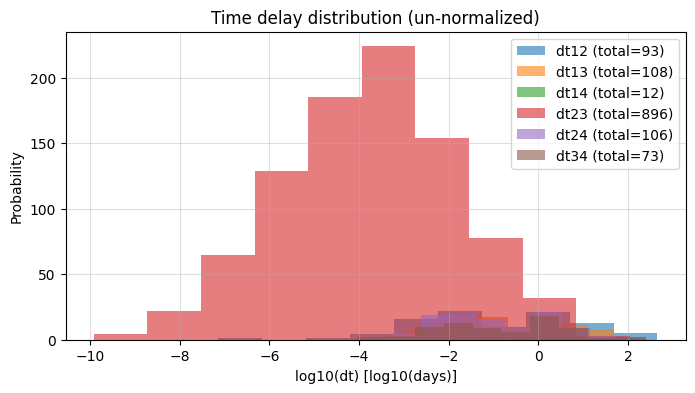

In [222]:
# plot
plt.figure(figsize=(8,4))
plt.hist(np.log10(dt12), bins=10, alpha=0.6, density=False, label='dt12 (total={})'.format(len(dt12)))
plt.hist(np.log10(dt13), bins=10, alpha=0.6, density=False, label='dt13 (total={})'.format(len(dt13)))
plt.hist(np.log10(dt14), bins=10, alpha=0.6, density=False, label='dt14 (total={})'.format(len(dt14)))
plt.hist(np.log10(dt23), bins=10, alpha=0.6, density=False, label='dt23 (total={})'.format(len(dt23)))
plt.hist(np.log10(dt24), bins=10, alpha=0.6, density=False, label='dt24 (total={})'.format(len(dt24)))
plt.hist(np.log10(dt34), bins=10, alpha=0.6, density=False, label='dt34 (total={})'.format(len(dt34)))
plt.xlabel('log10(dt) [log10(days)]')
plt.ylabel('Probability')
plt.title('Time delay distribution (un-normalized)')
#plt.xlim(-3.0, 8.0)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [225]:
1e-3*86400

86.4

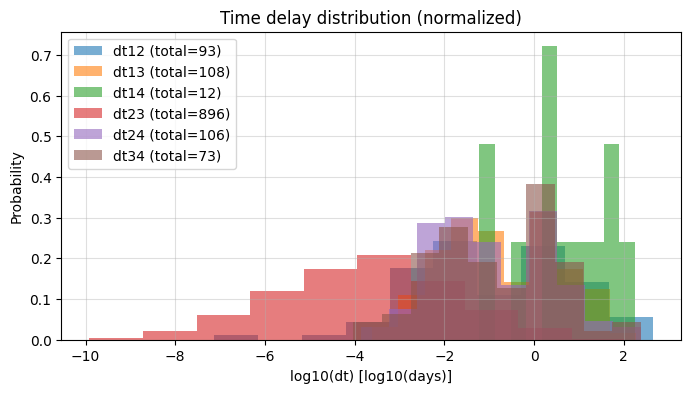

In [223]:
# plot
plt.figure(figsize=(8,4))
plt.hist(np.log10(dt12), bins=10, alpha=0.6, density=True, label='dt12 (total={})'.format(len(dt12)))
plt.hist(np.log10(dt13), bins=10, alpha=0.6, density=True, label='dt13 (total={})'.format(len(dt13)))
plt.hist(np.log10(dt14), bins=10, alpha=0.6, density=True, label='dt14 (total={})'.format(len(dt14)))
plt.hist(np.log10(dt23), bins=10, alpha=0.6, density=True, label='dt23 (total={})'.format(len(dt23)))
plt.hist(np.log10(dt24), bins=10, alpha=0.6, density=True, label='dt24 (total={})'.format(len(dt24)))
plt.hist(np.log10(dt34), bins=10, alpha=0.6, density=True, label='dt34 (total={})'.format(len(dt34)))
plt.xlabel('log10(dt) [log10(days)]')
plt.ylabel('Probability')
plt.title('Time delay distribution (normalized)')
#plt.xlim(-3.0, 8.0)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [210]:
lensed_params_detectable = get_param_from_json("ler_data/n_lensed_detectable_bns_uniformL1_new.json")

snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
mu = lensed_params_detectable['magnifications'].flatten()
mu_arr8 = abs(mu[np.where(snr_l>8)[0]])
# between 4 and 8
mu_arr4 = abs(mu[np.where((snr_l>4) & (snr_l<8))[0]])

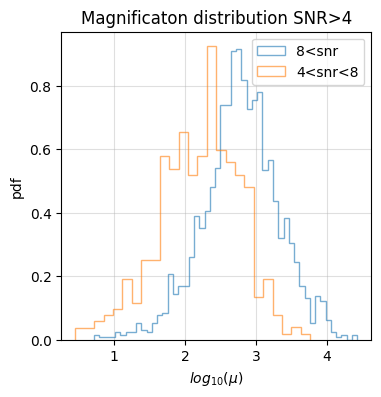

In [214]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.hist(np.log10(mu_arr8), bins=50, alpha=0.6, density=True, histtype='step', label='8<snr')
plt.hist(np.log10(mu_arr4), bins=25, alpha=0.6, density=True, histtype='step', label='4<snr<8')
plt.xlabel(r'$log_{10}(\mu)$')
plt.ylabel('pdf')
plt.title(r'Magnificaton distribution SNR>4')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

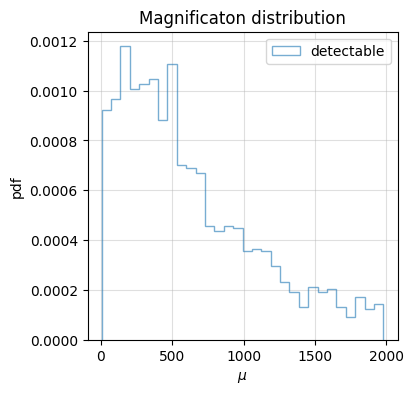

In [67]:
plt.figure(figsize=(4,4))
plt.hist(mu_arr2[mu_arr2<2000], bins=30, alpha=0.6, density=True, histtype='step', label='detectable')

plt.xlabel(r'$\mu$')
plt.ylabel('pdf')
plt.title(r'Magnificaton distribution')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

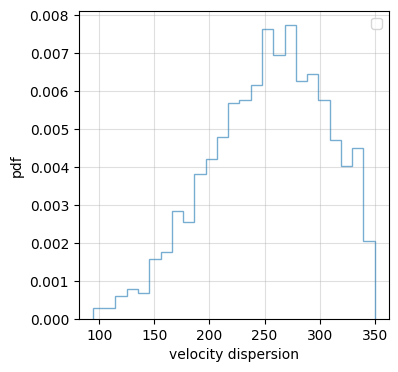

In [68]:
plt.figure(figsize=(4,4))
plt.hist(lensed_params_detectable['sigma'], bins=25, alpha=0.6, density=True, histtype='step')
plt.xlabel('velocity dispersion')
plt.ylabel('pdf')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [ ]:
ler.batch_size = 10000
lensed_params = ler.lensed_cbc_statistics(size=10000, output_jsonfile='lensed_cbc_statistics_test.json', resume=False)

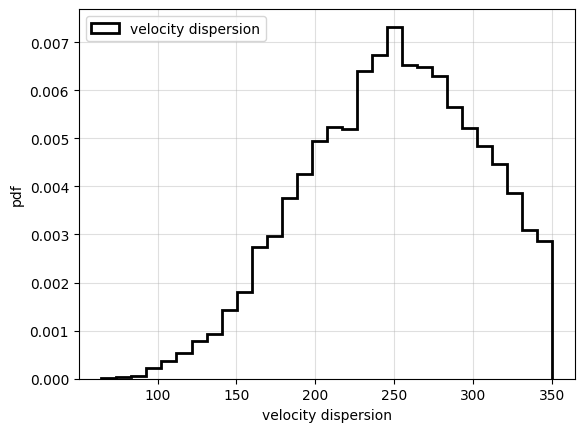

In [5]:
import matplotlib.pyplot as plt

plt.hist(lensed_params['sigma'], bins=30, histtype='step', lw=2, color='k', label='velocity dispersion', density=True)
plt.xlabel('velocity dispersion')
plt.ylabel('pdf')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [49]:
lens_param = ler.lensed_cbc_statistics(size=50000, resume=False)

lensed params will be store in ./ler_data/lensed_param.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3471.35it/s]


Invalid sample found. Resampling 1 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


calculating snrs...
saving all lensed_params in ./ler_data/lensed_param.json...


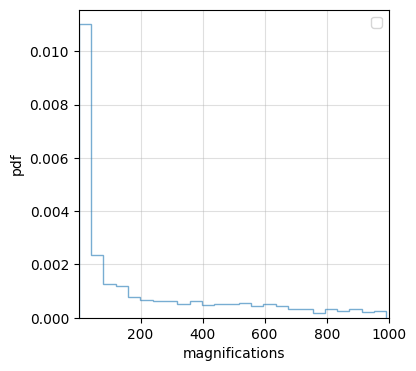

In [32]:
mu = abs(lensed_params_detectable['magnifications'].flatten())
mu_arr = np.sort(mu[(mu<1000)&(mu>1)])
plt.figure(figsize=(4,4))
plt.hist(mu_arr, bins=25, alpha=0.6, density=True, histtype='step')
# plt.plot(mu_arr, 0.1*mu_arr**(-3))
plt.xlabel('magnifications')
plt.ylabel('pdf')
plt.xlim(1,1000)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

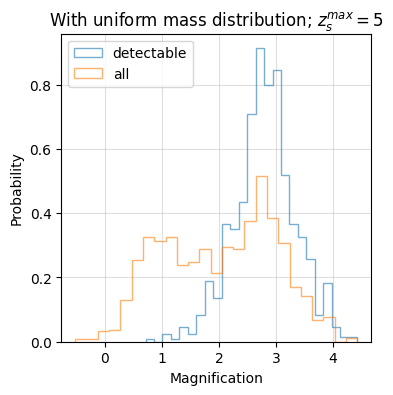

In [31]:
import matplotlib.pyplot as plt

mu_arr = abs(lensed_params_detectable['magnifications'].flatten())

plt.figure(figsize=(4,4))
plt.hist(np.log10(mu_arr2), bins=25, alpha=0.6, density=True, histtype='step', label='detectable')
plt.hist(np.log10(mu_arr), bins=25, alpha=0.6, density=True, histtype='step', label='all')
plt.xlabel('Magnification')
plt.ylabel('Probability')
plt.title(r'With uniform mass distribution; $z_s^{max}=5$')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

In [38]:
lensed_params_detectable.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net', 'L1'])

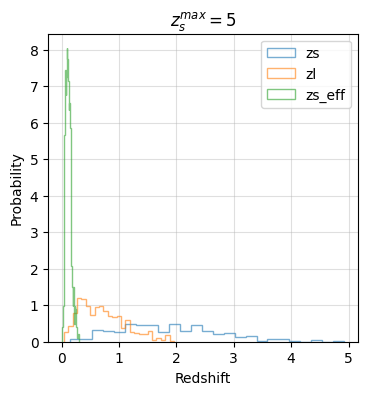

In [45]:
# plot resdhift lens and source
zs_source = lensed_params_detectable['zs']
zs_lens = lensed_params_detectable['zl']
# select only events snr>8
snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
idx = np.where(snr_l>8)[0]
zs_source = np.array([zs_source, zs_source, zs_source, zs_source]).flatten()
zs_lens = np.array([zs_lens, zs_lens, zs_lens, zs_lens]).flatten()
zs_source = zs_source[idx]
zs_lens = zs_lens[idx]
# effective zs
dl_eff = lensed_params_detectable['effective_luminosity_distance'].flatten()
dl_eff = dl_eff[idx]
# convert to redshift
zs_eff = ler.Dl_to_z(dl_eff)

plt.figure(figsize=(4,4))
plt.hist(zs_source, bins=25, alpha=0.6, density=True, histtype='step', label='zs')
plt.hist(zs_lens, bins=25, alpha=0.6, density=True, histtype='step', label='zl')
plt.hist(zs_eff, bins=25, alpha=0.6, density=True, histtype='step', label='zs_eff')
plt.xlabel('Redshift')
plt.ylabel('Probability')
plt.title(r'$z_s^{max}=5$')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

In [33]:
lensed_params_detectable.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net', 'L1'])

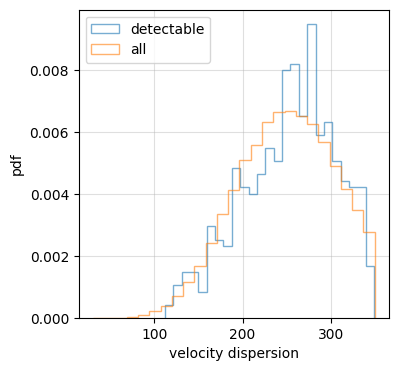

In [51]:
plt.figure(figsize=(4,4))
plt.hist(lensed_params_detectable['sigma'], bins=25, alpha=0.6, density=True, histtype='step', label='detectable')
plt.hist(lens_param['sigma'], bins=25, alpha=0.6, density=True, histtype='step', label='all')
plt.xlabel('velocity dispersion')
plt.ylabel('pdf')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [6]:
# intergrate 8*mu**-3 from 2 to 1000
import scipy.integrate as quad

def integrand(mu):
    return 8*mu**-3

result, _ = quad.quad(integrand, 100, 10000)
print(f"fraction of mu>100: {result}")

percentage of mu>100: 0.03999600000000022


In [7]:
21/200000

0.000105

In [9]:
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
from ler.lens_galaxy_population import OpticalDepth
od2 = OpticalDepth(
    npool=4,
    z_min=0.001,
    z_max=10.0,
    optical_depth_function="optical_depth_SIS_hemanta",
    sampler_priors=dict(
        velocity_dispersion="velocity_dispersion_bernardi",
        axis_ratio="axis_ratio_rayleigh",
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min=0., vd_max=600),
        axis_ratio=dict(q_min=0.2, q_max=1),
    ),
    cosmology=cosmo,
    directory="./interpolator_pickle",
    #create_new_interpolator=True,
    )

od3 = OpticalDepth(
    npool=4,
    z_min=0.001,
    z_max=10.0,
    optical_depth_function="optical_depth_SIS_hemanta",
    sampler_priors=dict(
        velocity_dispersion="velocity_dispersion_bernardi",
        axis_ratio="axis_ratio_rayleigh",
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min=10., vd_max=350),
        axis_ratio=dict(q_min=0.2, q_max=1),
    ),
    cosmology=cosmo,
    directory="./interpolator_pickle",
    #create_new_interpolator=True,
    )

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_bernardi interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_bernardi/velocity_dispersion_bernardi_0.pickle
optical_depth_SIS_hemanta interpolator will be loaded from ./interpolator_pickle/optical_depth_SIS_hemanta/optical_depth_SIS_hemanta_0.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./i

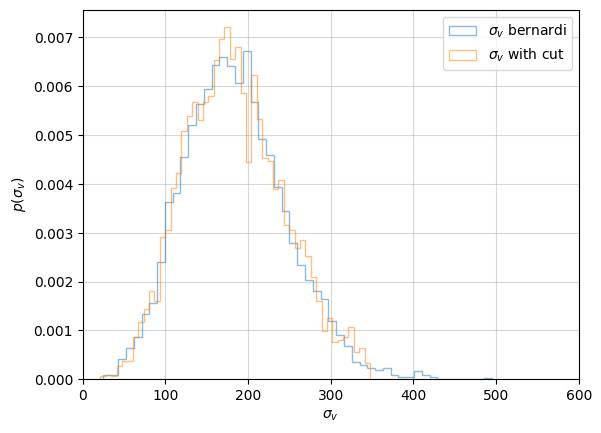

In [12]:
# plot hist
# sigma1 = od1.sample_velocity_dispersion(size=5000,)
sigma2 = od2.sample_velocity_dispersion(size=5000)
sigma3 = od3.sample_velocity_dispersion(size=5000)
# sigma4 = od4.sample_velocity_dispersion(size=5000, zl=1)
# sigma5 = od4.sample_velocity_dispersion(size=5000, zl=6)
# sigma6 = od5.sample_velocity_dispersion(size=5000, zl=6)
# plt.hist(sigma1, bins=50, density=True, alpha=0.5, label=r"$\sigma_v$ haris", histtype="step")
plt.hist(sigma2, bins=50, density=True, alpha=0.5, label="$\sigma_v$ bernardi", histtype="step")
plt.hist(sigma3, bins=50, density=True, alpha=0.5, label="$\sigma_v$ with cut", histtype="step")
# plt.hist(sigma4, bins=50, density=True, alpha=0.5, label="$\sigma_v$ ewoud $z_l=1$", histtype="step")
# plt.hist(sigma5, bins=50, density=True, alpha=0.5, label="$\sigma_v$ ewoud $z_l=6$", histtype="step")
# plt.hist(sigma6, bins=50, density=True, alpha=0.5, label="$\sigma_v$ $z_l=6$ Planck18", histtype="step")
plt.xlim(0, 600)
plt.xlabel(r"$\sigma_v$")
plt.ylabel(r"$p(\sigma_v)$")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

$\mathcal{R}\ _{min} = z_{min}$